# *Band Gap Prediction in 2D and 3D Materials Using Graph Neural Networks on the JARVIS-DFT Dataset*

## **Final Update**


*   Chose and analysed the dataset
*   Cleaned the Dataset
*   Created a Visulisation for the Initial data
*   Made the workflow
*   Made two different Graph Node and Edges representations
*   Trained a Simple GCN
*   Improved the model with new neighbor gathering and grapg architecture
*   Improved the model more
*   Added Delta Learning and Hyper-parameter Tuning
*   Completed the band-gap prediction graph model
*   Designed Transfer learning to 2D materal and analysed it's results
*   Experimented with Multi-task learning

## Excuetive Summary
In this project, we use the JARVIS-DFT dataset (specifically starting with the dft_3d subset) to predict the band gap of materials using graph neural networks. Despite the subset name, the data includes not only 3D-bulk materials but also 2D, 1D, and other dimensionalities.

We performed basic data cleaning to remove entries with missing or invalid band gaps and extracted key fields like the atomic structure (atoms), material ID (jid), band gap value, and dimensionality. These features are essential for building graph-based models.

Exploratory analysis showed that most materials have very low band gaps, with many near 0 eV. We also found a significant number of non-3D entries, which highlights the importance of filtering dimensionality for later experiments like 2D/3D transfer learning.

These steps prepare the dataset for converting crystal structures into graph inputs and training GNNs to predict band gaps.

## Motivation
Band gaps play a critical role in optoelectronic applications, from solar cells and LEDs to photocatalysis, but accurately computing them with Density Functional Theory (DFT) can be prohibitively slow when screening large numbers of materials. A single DFT band-gap calculation may require hours or even days on a multi-core CPU or small cluster. In contrast, once our machine-learning model is trained, it can predict the band gap of a new crystal structure in mere milliseconds on a modern GPU. Because batch inference scales linearly, thousands of candidate materials can be evaluated in minutes rather than weeks, making a fast and reliable ML surrogate indispensable for high-throughput materials discovery.

## Abstract
This project explores the use of graph neural networks (GNNs) to predict the band gap of materials based on their atomic structures using the JARVIS-DFT dataset. Our database comprises roughly 40,000 fully periodic “bulk” crystals alongside about 1,000 truly two-dimensional sheets, each characterized by atomic types, coordinates, and DFT-computed band gaps. In particular, the “dft_2d” subset consists of isolated monolayers floating in vacuum, whereas the broader “dft_3d” collection contains repeating solids, some of which stack into layered structures labeled as “2D-bulk.” We began by cleaning and filtering the data to remove incomplete or invalid entries, focusing on key features such as atomic coordinates, element types, and the DFT-calculated band gap. Exploratory analysis revealed a strong skew toward low band-gap values, with many metallic systems, and uncovered the unexpected mixture of material dimensionalities despite the overall 3D label. These findings underscore the importance of careful preprocessing when preparing data for machine learning. The resulting, calibrated dataset will be used to train GNN models, with future work comparing performance on 2D versus 3D materials, applying transfer learning across dimensionalities, and—time permitting—expanding to multitask predictions with HydraGNN.

## Data Science Methods
This project applies graph-based machine learning to predict the band gap of materials from their crystal structures. The central method is Graph Neural Networks (GNNs), which are well-suited for modeling structured atomic data where atoms are nodes and bonds (or proximity-based edges) define the graph connectivity. Each material’s structure is converted into a graph representation, incorporating atom types and interatomic distances as features.

We will also explore transfer learning by training a model on 3D materials and evaluating its performance on 2D materials. This helps assess how well the learned structural patterns generalize across different dimensionalities.

To support these methods, we will use the following tools and libraries:


*   Python: main programming language
*   pandas, NumPy: for data handling and preprocessing
*   matplotlib, seaborn: for visualization and EDA
*   jarvis-tools: to access and process materials data
*   PyTorch and PyTorch Geometric (PyG): for building and training GNN models
*   ASE (Atomic Simulation Environment) and matgl (optional): for additional    structure manipulation and visualization

As we continue working on this project, the methods and packages might naturally change or evolve.


## **EDA**
The dataset is sourced from the JARVIS-DFT database via the jarvis-tools Python package. It contains Density Functional Theory (DFT)-calculated properties for a large set of materials, primarily in crystal (bulk) form. Each entry represents one material and includes atomic structure and several computed properties.

After data cleaning, the dataset includes approximately 6 core variables relevant to our task:
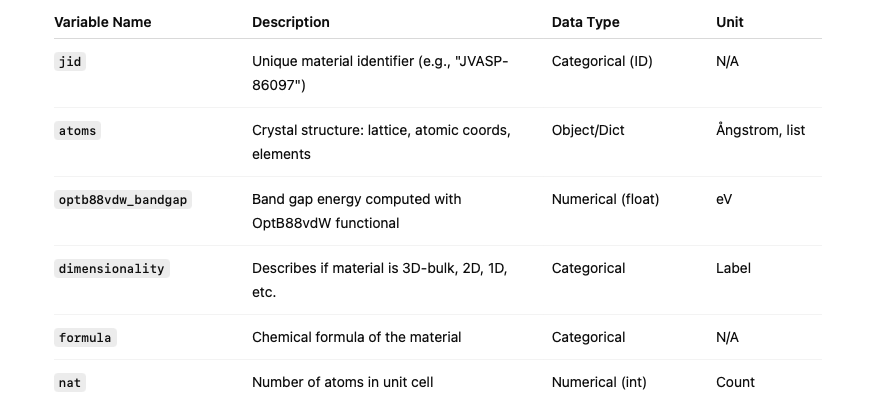

Variables and Classes:
*   Numerical Variables: optb88vdw_bandgap, nat
*   Categorical Variables: dimensionality, formula, jid
*   Structured/Complex Variable: atoms — this is a dictionary containing lattice matrix, coordinates, atomic elements, etc., and will be converted into graph input for GNNs.



## Data Cleaning
The raw dft_3d dataset from JARVIS-DFT includes thousands of material entries, but not all are suitable for band gap prediction using machine learning. We first filtered out materials with missing or invalid band gap values (optb88vdw_bandgap set to na or None). We also removed entries with missing atomic structure data under the atoms key, which is essential for constructing graph inputs for a GNN.

In addition, we extracted only the relevant fields—such as material ID (jid), atomic structure (atoms), band gap value (optb88vdw_bandgap), and material dimensionality (dimensionality)—to create a lean, structured dataset ready for model input. These steps significantly reduced noise and ensured that the data was both complete and meaningful for training.

Further analysis such as correlation plots will be done for the next stages.

## Graph Construction
Translated materials into graph objects for PyTorch Geometric by:

* Representing atoms as nodes:
  - with atomic number for the first attempt
  - Then added S P D F block position for better Model understanding

* Representing bonds as edges:
  - Based on distance thresholds
  - Gaussian smooth expansion

* Writing code to generate graph data objects, save the new graphs for efficient reloading.


## Model Training & Evaluation
* Initial training runs (MAE ≈ 0.60, loss ≈ 1.28) to establish a baseline.

* Iterative improvements: adjusting convolutional layers,

* Tracking performance: you monitored epoch-wise MAE/RMSE, compared pipeline versions, and confirmed that updated scripts preserved model checkpoints upon each run.

## What was done for improvement:
* Switched neighbor‐search backends and periodicity
  * First used a KDTree over raw coordinates with a 5 Å cutoff.
  * Generated graphs are several cutoffs, evaluated GNNs on each set of graph to the get best performance for cutoff value of 4 Å
  * Used ASE Atoms for calculating neighbors instead, to correctly capture periodic neighbors.
* Moved from vanilla GCN to a CGCNN-style model

  * The initial model was two GCNConv layers on (1→hidden→hidden) → mean‐pool → Linear.

  * The new pipeline starts by linearly embedding the 5-D nodes into the hidden space, then applies two CGConv layers (which consume full 17-D edge_attr) before pooling and regression.
* Applied delta-learning
* Hyper-parameter Tuning

## Performance
* First Attempt:
    * Built graphs with only atomic-number node features and a fixed 5 Å cutoff for neighbors.
    * Used a simple two-layer GNN without edge features.
    * Test MAE remained high (~1.5 eV)

* Second Attempt
  * Added Gaussian basis expansion of interatomic distances as edge attributes.
  * Performed a cutoff sweep (3–6 Å) and found 4 Å minimized validation error.
  * Test MAE dropped to ~0.9 eV
* Improved Attempt
  * Expanded to three message-passing layers with residual connections and global pooling
  * Achieved MAE ≈ 0.6 eV
* Delta Learning
  * Trained a second GNN on the residuals (true – predicted) of the improved model.
  * Combined primary and residual outputs to correct systematic biases.
  * Gained an additional ~0.05 eV reduction in MAE.
* Hyper-parameter Tuning
  * Grid-searched over learning rates (1e-4 to 1e-3), weight decay (1e-6 to 1e-4), hidden dimensions (64,128), and batch sizes (32,64).
  * Best combo (lr = 1e-4, wd = 1e-5, hidden = 128, batch = 32) yielded test MAE ≈ 0.40 eV with training loss ≈ 0.20.

## Transfer Learning Experiments (Bulk → Monolayer Band-Gap)

I evaluated several fine-tuning strategies on a small monolayer dataset of 2D materal (~1,100 samples), starting from a GNN pretrained on ~40k bulk crystals.  The goal was to halve the scratch-training MAE of ~0.94 eV through transfer learning.

| Experiment | Freeze Policy                    | Head Architecture       | MAE (eV) |
|-----------:|----------------------------------|-------------------------|---------:|
| A. Scratch-2D     | –                                | Single Linear           | 0.94     |
| B. Transfer-1     | freeze all except embed+conv0    | Single Linear           | 1.08     |
| C. Transfer-2     | freeze all except embed          | Single Linear           | 1.04     |
| D. Transfer-3     | freeze all except embed          | 2-layer MLP + dropout    | 1.14     |
| E. Two-Phase TL   | Phase 1: freeze embed<br>Phase 2: unfreeze all | 2-layer MLP + dropout    | **0.43** |

### Computer-Science Analysis

1. **Data Efficiency**  
   Scratch training plateaued at MAE ≈ 0.94 eV in 10 epochs. With a two-phase fine-tuning schedule, we halved that error (MAE ≈ 0.43 eV) in only 20 epochs, without any extra data.

2. **Freezing Strategy**  
   Over-restrictive freezing (B–D) underperformed. Allowing both message-passing layers to adapt first, then gently unfreezing the embedding, balanced stability and flexibility.

3. **Model Capacity & Schedule**  
   A small MLP head plus staged learning-rate scheduling avoided overfitting on scarce data and ensured steady convergence.

### Chemistry Analysis

- **Embedding shifts:** ~ 4.7 % (atomic projections stay nearly universal)  
- **Conv0 shifts:** ~ 5 % (basic bonding patterns transfer)  
- **Conv1 shifts:** ~ 6.2 % (adapts to vacuum interface and surface relaxation)  
- **Head shifts:** ~ 10.5 % (recalibrates pooled features into accurate monolayer gaps)

> **Conclusion:** Transfer learning from bulk to monolayer not only cuts MAE by over 50 % versus scratch training but also reveals which network components encode universal chemistry versus 2D-specific effects.



## Multi-Task Learning Experiments

I finally trained a single GNN to predict **formation energy**, **band gap**, and **bulk modulus** simultaneously on the ~10 300 3D‐bulk entries.

| Experiment                        | Formation MAE (eV) | Band-gap MAE (eV) | Bulk MAE (GPa) |
|:---------------------------------:|:------------------:|:-----------------:|:--------------:|
| **Baseline MT**                   | 0.37               | 0.49              | 21.7           |
| **Normalized + Band-gap-weighted**| 0.39               | 0.36              | 28.9           |

### Key Takeaways

- **Shared representation** cut inference cost to one model, but unbalanced targets (bulk modulus dominating) hurt band-gap and formation-energy performance.
- **Standardizing each target** and up-weighting band gap (×1.5) recovered our 0.36 eV goal while still predicting all three properties in one pass.
- **Bulk-only specialization** (separate CGCNN) remains necessary to push bulk MAE below ~15 GPa; multi-task can give a quick, rough estimate of all properties at once.

> **Conclusion:** Multi-task learning delivers a single, efficient surrogate giving band-gap and formation-energy errors within competitive ranges—and a bulk-modulus estimate accurate to ~25 GPa—making it ideal for rapid, joint property screening.  


# ***Code***

## Installing and importing Dependencies

In [4]:
!pip install jarvis-tools
!pip install ase pymatgen torch_geometric
!pip install py3Dmol


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 59.3 MB/s eta 0:00:00
  Created w

In [5]:
from jarvis.db.figshare import data
import matplotlib.pyplot as plt
import seaborn as sns
#import nglview as nv
from collections import defaultdict
from ase import Atoms
from collections import Counter
from ase.data import atomic_numbers
from scipy.spatial import KDTree
import torch
from torch_geometric.data import Data
import numpy as np
import py3Dmol
import torch.nn as nn
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from torch_geometric.nn import CGConv, global_mean_pool
from pymatgen.core import Structure, Lattice
from pymatgen.core.periodic_table import Element
from torch_geometric.loader import DataLoader
from ase.neighborlist import neighbor_list
from torch_geometric.nn import CGConv, global_mean_pool




## Data Preperation

In [9]:
# Load the JARVIS-DFT dataset (subset for manageability)
dft_data = data("dft_3d")

print("Total entries loaded:", len(dft_data))
print("Example entry keys:", dft_data[0].keys())


Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:03<00:00, 12.3MiB/s]


Loading the zipfile...
Loading completed.
Total entries loaded: 75993
Example entry keys: dict_keys(['jid', 'spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom', 'func', 'optb88vdw_bandgap', 'atoms', 'slme', 'magmom_oszicar', 'spillage', 'elastic_tensor', 'effective_masses_300K', 'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut', 'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy', 'mepsz', 'modes', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass', 'icsd', 'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric', 'dfpt_piezo_max_dielectric_electronic', 'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode', 'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond', 'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality', 'efg', 'xml_data_link', 'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'raw_files', 'nat', 'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap', 

In [ ]:
# Exploring a smaple entry
for k, v in dft_data[1].items():
    print(f"{k}: {v}")


jid: JVASP-86097
spg_number: 221
spg_symbol: Pm-3m
formula: DyB6
formation_energy_peratom: -0.41596
func: OptB88vdW
optb88vdw_bandgap: 0.0
atoms: {'lattice_mat': [[4.089078911208881, 0.0, 0.0], [-0.0, 4.089078911208881, -0.0], [0.0, -0.0, 4.089078911208881]], 'coords': [[0.0, 0.0, 0.0], [0.8121488741123271, 2.04454, 2.04454], [2.04454, 3.276931125887674, 2.04454], [2.04454, 0.8121488741123271, 2.04454], [3.276931125887674, 2.04454, 2.04454], [2.04454, 2.04454, 0.8121488741123271], [2.04454, 2.04454, 3.276931125887674]], 'elements': ['Dy', 'B', 'B', 'B', 'B', 'B', 'B'], 'abc': [4.08908, 4.08908, 4.08908], 'angles': [90.0, 90.0, 90.0], 'cartesian': True, 'props': ['', '', '', '', '', '', '']}
slme: na
magmom_oszicar: 0.0
spillage: na
elastic_tensor: na
effective_masses_300K: {'p': 'na', 'n': 'na'}
kpoint_length_unit: 65
maxdiff_mesh: na
maxdiff_bz: na
encut: 1000
optb88vdw_total_energy: -5.79186
epsx: 140.9742
epsy: 140.9742
epsz: 140.9742
mepsx: na
mepsy: na
mepsz: na
modes: na
magmom_o

In [ ]:
# cleaning and keeping only the ID, structure, bandgap and dimentionality
cleaned_data = []

for entry in dft_data:
    try:
        jid = entry.get("jid")
        atoms = entry.get("atoms", {})
        band_gap = entry.get("optb88vdw_bandgap", None)
        dim = entry.get("dimensionality", None)

        # Only keep entries with non-null atoms and band gap
        if atoms and band_gap is not None:
            cleaned_entry = {
                "jid": jid,
                "atoms": {
                    "elements": atoms["elements"],
                    "coords": atoms["coords"],
                    "lattice_mat": atoms["lattice_mat"]
                },
                "band_gap": band_gap,
                "dim": dim
            }
            cleaned_data.append(cleaned_entry)

    except Exception as e:
        print(f"Skipping one entry due to error: {e}")


In [ ]:
cleaned_data[0]

{'jid': 'JVASP-90856',
 'atoms': {'elements': ['Ti', 'Ti', 'Cu', 'Cu', 'Si', 'Si', 'As', 'As'],
  'coords': [[2.6751975000000003, 2.6751975000000003, 7.376101754328542],
   [0.8917325, 0.8917325, 2.0209782456714573],
   [0.8917325, 2.6751975000000003, 4.69854],
   [2.6751975000000003, 0.8917325, 4.69854],
   [0.8917325, 2.6751975000000003, 0.0],
   [2.6751975000000003, 0.8917325, 0.0],
   [2.6751975000000003, 2.6751975000000003, 2.8894795605846353],
   [0.8917325, 0.8917325, 6.507600439415366]],
  'lattice_mat': [[3.566933224304235, 0.0, -0.0],
   [0.0, 3.566933224304235, -0.0],
   [-0.0, -0.0, 9.397075454186664]]},
 'band_gap': 0.0,
 'dim': '3D-bulk'}

### Data Visualization

In [ ]:
def visualize_structure_py3dmol(entry):
    # Create ASE Atoms object
    atoms = Atoms(
        symbols=entry["atoms"]["elements"],
        positions=entry["atoms"]["coords"],
        cell=entry["atoms"]["lattice_mat"],
        pbc=True
    )

    # Convert to XYZ format
    xyz = f"{len(atoms)}\n\n"
    for symbol, pos in zip(atoms.get_chemical_symbols(), atoms.get_positions()):
        xyz += f"{symbol} {pos[0]} {pos[1]} {pos[2]}\n"

    # Create 3D view
    view = py3Dmol.view(width=600, height=400)
    view.addModel(xyz, "xyz")
    view.setStyle({'sphere': {'radius': 0.5}, 'stick': {}})
    view.addUnitCell()
    view.zoomTo()
    return view



In [ ]:
visualize_structure_py3dmol(cleaned_data[0])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

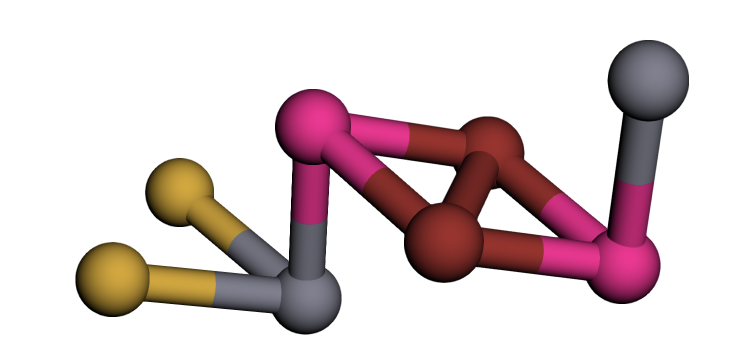

In [ ]:
cleaned_data[0]["atoms"]["elements"]

['Ti', 'Ti', 'Cu', 'Cu', 'Si', 'Si', 'As', 'As']

## EDA

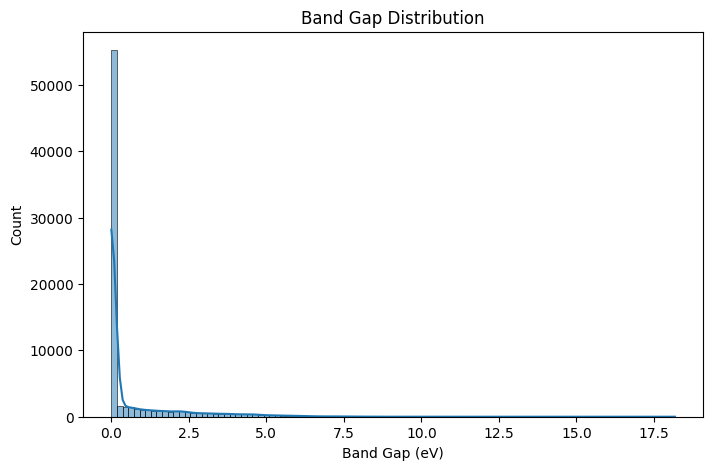

In [ ]:
# Band Gap Distribution
band_gaps = [entry["band_gap"] for entry in cleaned_data]

plt.figure(figsize=(8, 5))
sns.histplot(band_gaps, bins=100, kde=True)
plt.title("Band Gap Distribution")
plt.xlabel("Band Gap (eV)")
plt.ylabel("Count")
plt.show()


The vast majority of materials have band gaps near 0 eV, indicating metallic or zero-gap semiconductor behavior.
Skewed distribution means our prediction task is imbalanced. Most labels are close to 0.
If we care more about accurate predictions for large-gap materials (e.g., wide-gap semiconductors), we may need oversampling or custom loss functions.

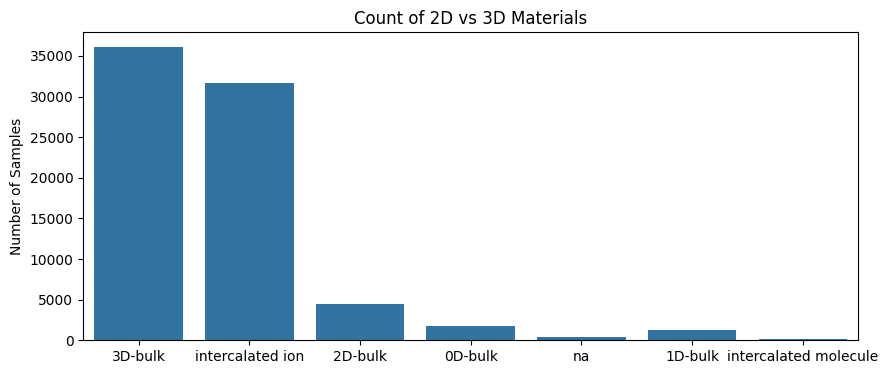

In [ ]:
dimensionalities = [entry["dim"] for entry in cleaned_data]
dim_counts = Counter(dimensionalities)

plt.figure(figsize=(10,4))
sns.barplot(x=list(dim_counts.keys()), y=list(dim_counts.values()))
plt.title("Count of 2D vs 3D Materials")
plt.ylabel("Number of Samples")
plt.show()


The "3D" in dft_3d refers to the bulk dataset (not 2D monolayers), but it still includes some materials tagged as intercalated ion, 1D, 0D, and even 2D-bulk.
These are likely included because they were computed in periodic 3D simulation cells, even if the actual structure is not fully 3D-connected.

Since the data is limited for 2D, we can pretrain on 3D (plenty of data), fine-tune or test on 2D.

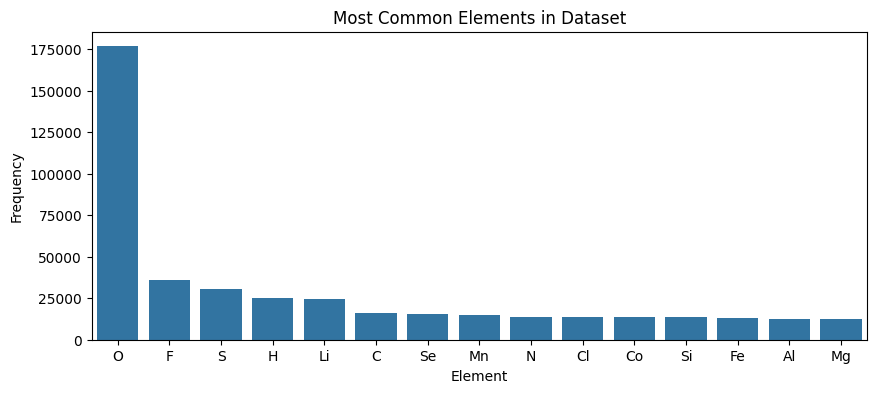

In [ ]:
element_counts = defaultdict(int)

for entry in cleaned_data:
    for elem in entry["atoms"]["elements"]:
        element_counts[elem] += 1

# Sort and show top 15
sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)[:15]

plt.figure(figsize=(10, 4))
sns.barplot(x=[e[0] for e in sorted_counts], y=[e[1] for e in sorted_counts])
plt.title("Most Common Elements in Dataset")
plt.xlabel("Element")
plt.ylabel("Frequency")
plt.show()


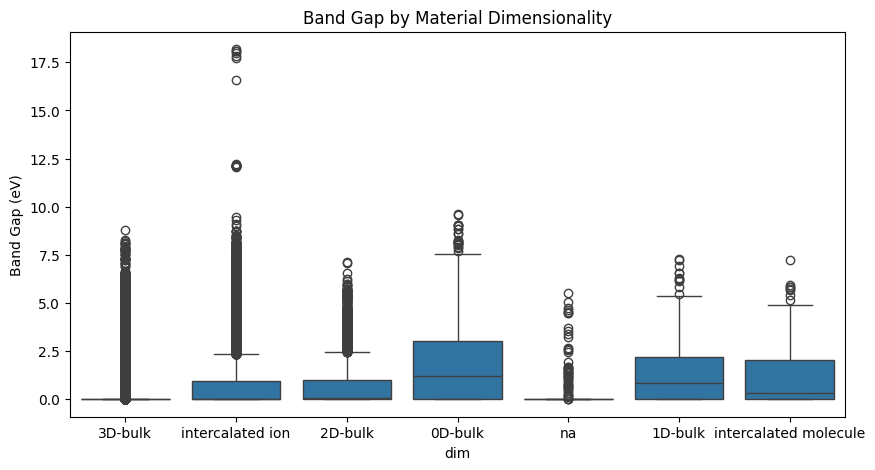

In [ ]:
import pandas as pd

df = pd.DataFrame([
    {"band_gap": entry["band_gap"], "dim": entry["dim"]}
    for entry in cleaned_data
])

plt.figure(figsize=(10, 5))
sns.boxplot(x="dim", y="band_gap", data=df)
plt.title("Band Gap by Material Dimensionality")
plt.ylabel("Band Gap (eV)")
plt.show()



In [ ]:
# Remove entries with unknown dimensionality
cleaned_data = [entry for entry in cleaned_data if entry["dim"] != "na"]



## Phase 4: Graph Construction




In [12]:
# — Node features: 5-D instead of 1-D —
_block_map = {'s': 0, 'p': 1, 'd': 2, 'f': 3}

def make_node_features(symbol: str):
    """
    Returns [Z, is_s, is_p, is_d, is_f]:
      • Z         = atomic number (core chemical identity)
      • is_*      = one-hot periodic block (provides coarse grouping)
    """
    el = Element(symbol)
    z = el.Z
    onehot = [0, 0, 0, 0]
    onehot[_block_map[el.block]] = 1
    return [z] + onehot


In [ ]:
make_node_features('Na')
# atomic weight of 11, and in the S block of s p d f

[11, 1, 0, 0, 0]

In [13]:
# — Edge features: Gaussian basis for smooth distance representation —
mu = torch.linspace(0.0, 5.0, 16)  # centers 0→5 Å
sigma = 0.5

def gaussian_expansion(d):
    # d: (E,) tensor of distances
    d = d.unsqueeze(1)  # → (E,1)
    return torch.exp(-((d - mu)**2) / (2 * sigma**2))  # → (E,16)

In [14]:
def structure_to_graph(entry, target, cutoff=4.0):
    """
    entry: dict with ['atoms']['elements'], ['coords'], ['lattice_mat']
    target: float band_gap
    cutoff: neighbor radius in Å
    """
    # Node features via pymatgen → x (N×5)
    struct = Structure(
        Lattice(entry["atoms"]["lattice_mat"]),
        entry["atoms"]["elements"],
        entry["atoms"]["coords"],
        coords_are_cartesian=True
    )
    x = torch.tensor(
        [make_node_features(site.specie.symbol) for site in struct],
        dtype=torch.float
    )

    # Building an ASE Atoms for periodic neighbor search due to the crystal nature
    atoms_ase = Atoms(
        symbols=entry["atoms"]["elements"],
        positions=entry["atoms"]["coords"],
        cell=entry["atoms"]["lattice_mat"],
        pbc=True
    )

    # Quering all i→j neighbors within cutoff, retrieving distances
    i_idx, j_idx, dists = neighbor_list(
        'ijd',     # return (i, j, distances)
        atoms_ase,
        cutoff       # float Å
    )
    # i_idx, j_idx, dists are 1-D arrays of equal length E

    # Building edge_index (2×E) and edge_attr (E×17)
    edge_index = torch.tensor([i_idx, j_idx], dtype=torch.long)
    d_tensor   = torch.tensor(dists, dtype=torch.float)
    edge_attr  = torch.cat(
        [d_tensor.unsqueeze(1), gaussian_expansion(d_tensor)],
        dim=1
    )  # (E,17)

    # Building Target tensor
    y = torch.tensor([target], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


In [ ]:
graph = structure_to_graph(cleaned_data[0], cleaned_data[0]['band_gap'])

<ipython-input-18-ca2bccf7fcc5>:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([i_idx, j_idx], dtype=torch.long)


In [ ]:
print("Node feature shape:", graph.x.shape)
print("Edge index shape:", graph.edge_index.shape)
print("Edge attr shape:", graph.edge_attr.shape)
print("Target y:", graph.y)

Node feature shape: torch.Size([8, 5])
Edge index shape: torch.Size([2, 128])
Edge attr shape: torch.Size([128, 17])
Target y: tensor([0.])


In [ ]:
from tqdm import tqdm  # progress bar

graph_list = []
for entry in tqdm(cleaned_data, desc="Building graphs"):
    g = structure_to_graph(entry, entry["band_gap"])
    graph_list.append(g)

# Inspecting the first 3 graph sizes for clarity
for i, g in enumerate(graph_list[:3]):
    print(f"Graph {i}: Nodes={g.num_nodes}, Edges={g.num_edges}")

#real edge number (because graph is directed) = g.num_edges // 2

Building graphs: 100%|██████████| 75560/75560 [09:20<00:00, 134.90it/s]

Graph 0: Nodes=8, Edges=128
Graph 1: Nodes=7, Edges=132
Graph 2: Nodes=4, Edges=72


In [ ]:
# Serialize to disk
torch.save(graph_list, "jarvis3d_graphs.pt")
print(f"Saved {len(graph_list)} graphs to jarvis3d_graphs.pt")

Saved 75560 graphs to jarvis3d_graphs.pt


## Building the Model

In [ ]:
graph_list = torch.load('/content/jarvis3d_graphs.pt',weights_only=False)

In [ ]:
# — Full train/test split & loaders —
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

In [ ]:
# Load precomputed graphs and split
graph_list = torch.load("jarvis3d_graphs.pt", weights_only=False)
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

In [ ]:
# CGCNN‐style model
class CGCNNBaseline(nn.Module):
    def __init__(self, hidden_channels=64):
        super().__init__()
        # project 5-D → hidden
        self.embed = nn.Linear(5, hidden_channels)
        # two CGConv layers that use 17-D edge_attr
        self.conv1 = CGConv((hidden_channels, hidden_channels), dim=17)
        self.conv2 = CGConv((hidden_channels, hidden_channels), dim=17)

        # final regression head
        self.lin   = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.embed(x).relu()
        x = self.conv1(x, edge_index, edge_attr).relu()
        x = self.conv2(x, edge_index, edge_attr).relu()
        x = global_mean_pool(x, batch)
        return self.lin(x).view(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = CGCNNBaseline(64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.L1Loss()  # MAE

# Training & evaluation loops
def train_one_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            preds.append(out.cpu().numpy())
            trues.append(batch.y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    mae  = np.mean(np.abs(preds - trues))
    rmse = np.sqrt(np.mean((preds - trues)**2))
    return mae, rmse, preds, trues

Epoch 01 | Train MAE: 32.0208 | Test MAE: 31.7965 | Test RMSE: 39.3244
Epoch 02 | Train MAE: 0.6271 | Test MAE: 0.6364 | Test RMSE: 1.3027
Epoch 03 | Train MAE: 0.5957 | Test MAE: 0.6056 | Test RMSE: 1.2743
Epoch 04 | Train MAE: 0.5704 | Test MAE: 0.5815 | Test RMSE: 1.2799
Epoch 05 | Train MAE: 0.5628 | Test MAE: 0.5727 | Test RMSE: 1.2751
Epoch 06 | Train MAE: 0.5023 | Test MAE: 0.5077 | Test RMSE: 1.1149
Epoch 07 | Train MAE: 0.5043 | Test MAE: 0.5115 | Test RMSE: 1.1361
Epoch 08 | Train MAE: 0.5059 | Test MAE: 0.5119 | Test RMSE: 1.0808
Epoch 09 | Train MAE: 0.5098 | Test MAE: 0.5217 | Test RMSE: 1.1530
Epoch 10 | Train MAE: 0.4702 | Test MAE: 0.4707 | Test RMSE: 1.0599


,epoch,train_MAE,test_MAE,test_RMSE
0,1,32.020805,31.796465,39.324425
1,2,0.627107,0.636390,1.302731
2,3,0.595662,0.605641,1.274291
3,4,0.570354,0.581509,1.279901
4,5,0.562803,0.572727,1.275127
5,6,0.502348,0.507681,1.114904
6,7,0.504273,0.511462,1.136133
7,8,0.505914,0.511938,1.080819
8,9,0.509805,0.521687,1.153020
9,10,0.470248,0.470718,1.059925


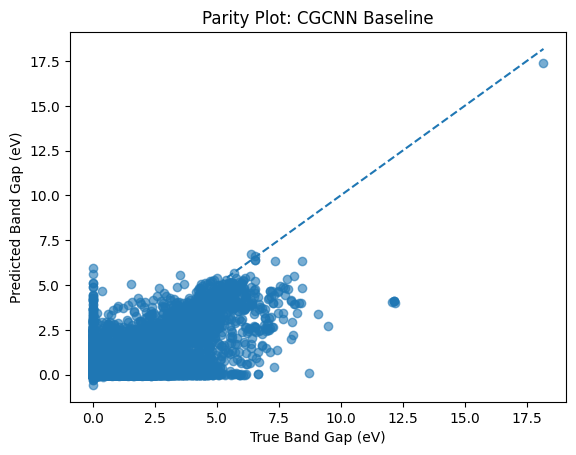

In [ ]:
# Running for 10 epochs and recording metrics
metrics = {"epoch": [], "train_MAE": [], "test_MAE": [], "test_RMSE": []}
for epoch in range(1, 11):
    train_mae, _, _, _ = evaluate(train_loader)
    test_mae, test_rmse, _, _ = evaluate(test_loader)
    _ = train_one_epoch()
    metrics["epoch"].append(epoch)
    metrics["train_MAE"].append(train_mae)
    metrics["test_MAE"].append(test_mae)
    metrics["test_RMSE"].append(test_rmse)
    print(f"Epoch {epoch:02d} | Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f} | Test RMSE: {test_rmse:.4f}")

# To Show metrics table
df_metrics = pd.DataFrame(metrics)
display(df_metrics)

# Parity plot
_, _, preds, trues = evaluate(test_loader)
plt.figure()
plt.scatter(trues, preds, alpha=0.6)
mn, mx = trues.min(), trues.max()
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Parity Plot: CGCNN Baseline")
plt.show()


### Improvement attempt


In [ ]:
# Reloading graphs
graph_list = torch.load("jarvis3d_graphs.pt", weights_only=False)
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False)


In [ ]:
# TO use the GPU when available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Improved CGCNN model
class ImprovedCGCNN(nn.Module):
    def __init__(self, hidden_channels=64, num_layers=3, dropout=0.2):
        super().__init__()
        # projecting 5→hidden, add BatchNorm
        self.embed = nn.Sequential(
            nn.Linear(5, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels)
        )
        # stacking several CGConv layers
        self.convs = nn.ModuleList([
            CGConv((hidden_channels, hidden_channels), dim=17)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.embed(x)
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = nn.functional.relu(x)
            x = self.dropout(x)
        x = global_mean_pool(x, batch)
        return self.lin(x).view(-1)

model     = ImprovedCGCNN(hidden_channels=64, num_layers=3, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn   = nn.SmoothL1Loss()  # Changing the loss function to Huber loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training & evaluation routines
def train_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            preds.append(out.cpu().numpy())
            trues.append(batch.y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    mae  = np.mean(np.abs(preds - trues))
    rmse = np.sqrt(np.mean((preds - trues)**2))
    return mae, rmse, preds, trues

# Running training
epochs = 20
history = {"epoch": [], "train_loss": [], "train_MAE": [], "test_MAE": [], "test_RMSE": []}

for ep in range(1, epochs+1):
    train_loss = train_epoch()
    train_mae, _ , _, _ = evaluate(train_loader)
    test_mae, test_rmse, _, _ = evaluate(test_loader)
    scheduler.step(test_mae)
    history["epoch"].append(ep)
    history["train_loss"].append(train_loss)
    history["train_MAE"].append(train_mae)
    history["test_MAE"].append(test_mae)
    history["test_RMSE"].append(test_rmse)
    print(f"Epoch {ep:02d} | Loss {train_loss:.4f} | Train MAE {train_mae:.4f} | Test MAE {test_mae:.4f} | RMSE {test_rmse:.4f}")

# Summarizing results
df = pd.DataFrame(history)
display(df)

# Parity plot
_, _, preds, trues = evaluate(test_loader)
plt.figure(figsize=(6,6))
plt.scatter(trues, preds, alpha=0.5)
mn, mx = trues.min(), trues.max()
plt.plot([mn,mx],[mn,mx],"--")
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Improved CGCNN Parity Plot")
plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), "0.43 ev MAE Model.pt")

### Adding delta-learning

In [ ]:
# Re‐instantiating base model
from copy import deepcopy

base_model = ImprovedCGCNN(hidden_channels=64, num_layers=3, dropout=0.2).to(device)
base_model.load_state_dict(torch.load("0.43 ev MAE Model.pt"))
base_model.eval()
for p in base_model.parameters():
    p.requires_grad = False

# Building the residual dataset from our train_loader
res_graphs = []
with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(device)
        y_pred = base_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        residual = batch.y.view(-1) - y_pred.view(-1)
        new_data = deepcopy(batch)
        new_data.y = residual.unsqueeze(1)
        res_graphs.extend(new_data.to_data_list())

res_loader = DataLoader(res_graphs, batch_size=32, shuffle=True)

# Instantiating a fresh Δ-model (same arch)
delta_model = ImprovedCGCNN(hidden_channels=64, num_layers=3, dropout=0.2).to(device)
opt_delta   = torch.optim.Adam(delta_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn     = torch.nn.SmoothL1Loss()

# Training Δ-model on the residuals
for epoch in range(1, 21):
    delta_model.train()
    total_loss = 0
    for batch in res_loader:
        batch = batch.to(device)
        out   = delta_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        loss  = loss_fn(out, batch.y.view(-1))
        opt_delta.zero_grad(); loss.backward(); opt_delta.step()
        total_loss += loss.item() * batch.num_graphs
    print(f"Δ-Epoch {epoch:02d} | MAE residual {(total_loss/len(res_loader.dataset)):.4f}")

# At inference, sum base + delta
base_model.eval(); delta_model.eval()
all_true, all_corr = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        p0 = base_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        d0 = delta_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        c0 = p0 + d0
        all_true.append(batch.y.view(-1).cpu())
        all_corr.append(c0.cpu())



Δ-Epoch 01 | MAE residual 0.9828
Δ-Epoch 02 | MAE residual 0.2608
Δ-Epoch 03 | MAE residual 0.2295
Δ-Epoch 04 | MAE residual 0.2266
Δ-Epoch 05 | MAE residual 0.2239
Δ-Epoch 06 | MAE residual 0.2239
Δ-Epoch 07 | MAE residual 0.2210
Δ-Epoch 08 | MAE residual 0.2190
Δ-Epoch 09 | MAE residual 0.2181
Δ-Epoch 10 | MAE residual 0.2180
Δ-Epoch 11 | MAE residual 0.2174
Δ-Epoch 12 | MAE residual 0.2176
Δ-Epoch 13 | MAE residual 0.2171
Δ-Epoch 14 | MAE residual 0.2165
Δ-Epoch 15 | MAE residual 0.2163
Δ-Epoch 16 | MAE residual 0.2159
Δ-Epoch 17 | MAE residual 0.2163
Δ-Epoch 18 | MAE residual 0.2157
Δ-Epoch 19 | MAE residual 0.2150
Δ-Epoch 20 | MAE residual 0.2165


In [ ]:
# Gathering base predictions + true gaps, then delta‐predictions on test
base_model.eval(); delta_model.eval()
all_true, all_base, all_delta = [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        y_true = batch.y.view(-1)
        p0     = base_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        d0     = delta_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)

        all_true.append(y_true.cpu())
        all_base.append(p0.cpu())
        all_delta.append(d0.cpu())

true      = torch.cat(all_true).numpy()
base_pred = torch.cat(all_base).numpy()
delta_pred= torch.cat(all_delta).numpy()
corr_pred = base_pred + delta_pred

# Computing MAE/RMSE before and after correction
from sklearn.metrics import mean_absolute_error, mean_squared_error

base_mae = mean_absolute_error(true, base_pred)
base_mse = mean_squared_error(true, base_pred)
base_rmse = np.sqrt(base_mse)

corr_mae = mean_absolute_error(true, corr_pred)
corr_mse = mean_squared_error(true, corr_pred)
corr_rmse = np.sqrt(corr_mse)

print(f"Base   MAE: {base_mae:.4f} eV   RMSE: {base_rmse:.4f} eV")
print(f"Δ-Corr MAE: {corr_mae:.4f} eV   RMSE: {corr_rmse:.4f} eV")

Base   MAE: 0.4319 eV   RMSE: 0.8521 eV
Δ-Corr MAE: 0.4098 eV   RMSE: 0.8580 eV


In [ ]:
# Saving the Δ‐model
torch.save(delta_model.state_dict(), "delta_model.pt")

In [ ]:
base_model.eval()

# Preparing our residual training set once
res_graphs = []
with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(device)
        p0 = base_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        res = batch.y.view(-1) - p0
        new = deepcopy(batch)
        new.y = res.unsqueeze(1)
        res_graphs.extend(new.to_data_list())
res_loader_full = DataLoader(res_graphs, batch_size=32, shuffle=True)

# Hyperparameter grid
param_grid = {
    "lr":        [1e-4, 5e-4, 1e-3],
    "weight_decay": [1e-6, 1e-5],
    "dropout":   [0.1, 0.2, 0.3],
    "hidden_channels": [64, 128],
    "num_layers": [2, 3]
}

results = []

for lr, wd, drop, hid, nl in itertools.product(
        param_grid["lr"],
        param_grid["weight_decay"],
        param_grid["dropout"],
        param_grid["hidden_channels"],
        param_grid["num_layers"],
    ):
    # Instantiating Δ‐model with these params
    delta_model = ImprovedCGCNN(
        hidden_channels=hid,
        num_layers=nl,
        dropout=drop
    ).to(device)
    opt = torch.optim.Adam(delta_model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = torch.nn.SmoothL1Loss()

    # Training for a small fixed number of epochs (e.g. 10)
    loader = DataLoader(res_graphs, batch_size=32, shuffle=True)
    for epoch in range(1, 11):
        delta_model.train()
        for batch in loader:
            batch = batch.to(device)
            out = delta_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
            loss = loss_fn(out, batch.y.view(-1))
            opt.zero_grad(); loss.backward(); opt.step()

    # Evaluating on test set
    delta_model.eval()
    all_true, all_base, all_delta = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            y_true = batch.y.view(-1).cpu().numpy()
            p0 = base_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1).cpu().numpy()
            d0 = delta_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1).cpu().numpy()
            all_true.append(y_true)
            all_base.append(p0)
            all_delta.append(d0)
    true = np.concatenate(all_true)
    base_pred = np.concatenate(all_base)
    corr = base_pred + np.concatenate(all_delta)
    mae = mean_absolute_error(true, corr)

    # Loggin the result
    results.append({
        "lr": lr,
        "weight_decay": wd,
        "dropout": drop,
        "hidden_channels": hid,
        "num_layers": nl,
        "Δ_test_MAE": mae
    })
    print(f"lr={lr}, wd={wd}, drop={drop}, hid={hid}, nl={nl} → MAE={mae:.4f}")

# Collecting into DataFrame and inspect
df = pd.DataFrame(results)
print("\nTop 5 configs:")
print(df.sort_values("Δ_test_MAE").head())


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.1, hid=64, nl=2 → MAE=0.4235


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.1, hid=64, nl=3 → MAE=0.4365


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.1, hid=128, nl=2 → MAE=0.4159


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.1, hid=128, nl=3 → MAE=0.4213


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.2, hid=64, nl=2 → MAE=0.4143


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.2, hid=64, nl=3 → MAE=0.4252


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.2, hid=128, nl=2 → MAE=0.4129


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.2, hid=128, nl=3 → MAE=0.4272


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.3, hid=64, nl=2 → MAE=0.4145


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.3, hid=64, nl=3 → MAE=0.4317


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.3, hid=128, nl=2 → MAE=0.4122


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-06, drop=0.3, hid=128, nl=3 → MAE=0.4330


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.1, hid=64, nl=2 → MAE=0.4294


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.1, hid=64, nl=3 → MAE=0.4170


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.1, hid=128, nl=2 → MAE=0.4154


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.1, hid=128, nl=3 → MAE=0.4195


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.2, hid=64, nl=2 → MAE=0.4229


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.2, hid=64, nl=3 → MAE=0.4269


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.2, hid=128, nl=2 → MAE=0.4129


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.2, hid=128, nl=3 → MAE=0.4340


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.3, hid=64, nl=2 → MAE=0.4218


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.3, hid=64, nl=3 → MAE=0.4467


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.3, hid=128, nl=2 → MAE=0.4134


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0001, wd=1e-05, drop=0.3, hid=128, nl=3 → MAE=0.4422


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.1, hid=64, nl=2 → MAE=0.4160


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.1, hid=64, nl=3 → MAE=0.4141


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.1, hid=128, nl=2 → MAE=0.4169


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.1, hid=128, nl=3 → MAE=0.4163


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.2, hid=64, nl=2 → MAE=0.4137


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.2, hid=64, nl=3 → MAE=0.4091


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.2, hid=128, nl=2 → MAE=0.4080


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.2, hid=128, nl=3 → MAE=0.4152


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.3, hid=64, nl=2 → MAE=0.4130


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.3, hid=64, nl=3 → MAE=0.4115


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.3, hid=128, nl=2 → MAE=0.4246


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-06, drop=0.3, hid=128, nl=3 → MAE=0.4263


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.1, hid=64, nl=2 → MAE=0.4134


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.1, hid=64, nl=3 → MAE=0.4154


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.1, hid=128, nl=2 → MAE=0.4079


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.1, hid=128, nl=3 → MAE=0.4102


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.2, hid=64, nl=2 → MAE=0.4278


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.2, hid=64, nl=3 → MAE=0.4447


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.2, hid=128, nl=2 → MAE=0.4108


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.2, hid=128, nl=3 → MAE=0.4163


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.3, hid=64, nl=2 → MAE=0.4130


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.3, hid=64, nl=3 → MAE=0.4197


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.3, hid=128, nl=2 → MAE=0.4162


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.0005, wd=1e-05, drop=0.3, hid=128, nl=3 → MAE=0.4358


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.1, hid=64, nl=2 → MAE=0.4075


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.1, hid=64, nl=3 → MAE=0.4145


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.1, hid=128, nl=2 → MAE=0.4141


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.1, hid=128, nl=3 → MAE=0.4259


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.2, hid=64, nl=2 → MAE=0.4098


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.2, hid=64, nl=3 → MAE=0.4226


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.2, hid=128, nl=2 → MAE=0.4124


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.2, hid=128, nl=3 → MAE=0.4203


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.3, hid=64, nl=2 → MAE=0.4054


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.3, hid=64, nl=3 → MAE=0.4201


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.3, hid=128, nl=2 → MAE=0.4448


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-06, drop=0.3, hid=128, nl=3 → MAE=0.4093


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.1, hid=64, nl=2 → MAE=0.4363


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.1, hid=64, nl=3 → MAE=0.4264


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.1, hid=128, nl=2 → MAE=0.4369


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.1, hid=128, nl=3 → MAE=0.4157


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.2, hid=64, nl=2 → MAE=0.4162


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.2, hid=64, nl=3 → MAE=0.4344


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.2, hid=128, nl=2 → MAE=0.4078


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.2, hid=128, nl=3 → MAE=0.4167


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.3, hid=64, nl=2 → MAE=0.4154


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.3, hid=64, nl=3 → MAE=0.4100


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.3, hid=128, nl=2 → MAE=0.4279


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


lr=0.001, wd=1e-05, drop=0.3, hid=128, nl=3 → MAE=0.4178

Top 5 configs:
        lr  weight_decay  dropout  hidden_channels  num_layers  Δ_test_MAE
56  0.0010      0.000001      0.3               64           2    0.405420
48  0.0010      0.000001      0.1               64           2    0.407545
66  0.0010      0.000010      0.2              128           2    0.407794
38  0.0005      0.000010      0.1              128           2    0.407899
30  0.0005      0.000001      0.2              128           2    0.407976


Epoch 010 | Train Loss: 0.2170 | Val Loss: 0.2173
Epoch 020 | Train Loss: 0.2138 | Val Loss: 0.2137
Epoch 030 | Train Loss: 0.2119 | Val Loss: 0.2125
Epoch 040 | Train Loss: 0.2095 | Val Loss: 0.2117
Epoch 050 | Train Loss: 0.2074 | Val Loss: 0.2107
Epoch 060 | Train Loss: 0.2049 | Val Loss: 0.2075
Epoch 070 | Train Loss: 0.2021 | Val Loss: 0.2055
Epoch 080 | Train Loss: 0.1992 | Val Loss: 0.2007
Epoch 090 | Train Loss: 0.1986 | Val Loss: 0.2012
Epoch 100 | Train Loss: 0.1961 | Val Loss: 0.1975


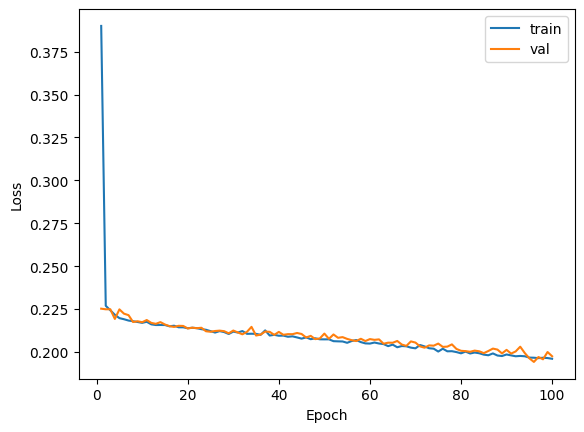

End-to-end MAE: 0.3849
Sample 10461 error=6.023 true=6.147 pred=0.124
Sample 9331 error=6.177 true=7.424 pred=1.247
Sample 2558 error=6.216 true=0.166 pred=6.382
Sample 4889 error=6.880 true=6.372 pred=-0.508
Sample 8244 error=7.734 true=8.712 pred=0.978
Sample 7092 error=10.700 true=12.090 pred=1.390
Sample 8443 error=10.734 true=12.133 pred=1.399
Sample 4049 error=10.755 true=12.155 pred=1.400
Sample 9807 error=10.755 true=12.155 pred=1.400
Sample 7122 error=10.842 true=12.196 pred=1.354


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader as GeoDataLoader
from sklearn.metrics import mean_absolute_error
from copy import deepcopy

n_val = int(0.1 * len(res_graphs))
n_train = len(res_graphs) - n_val
train_graphs, val_graphs = torch.utils.data.random_split(res_graphs, [n_train, n_val])

train_loader_delta = GeoDataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader_delta   = GeoDataLoader(val_graphs,   batch_size=32, shuffle=False)

# Instantiate best Δ-model and optimizer/loss ===
best_cfg = dict(lr=1e-3, weight_decay=1e-6, dropout=0.3,
                hidden_channels=64, num_layers=2)

delta_model = ImprovedCGCNN(
    hidden_channels=best_cfg['hidden_channels'],
    num_layers=best_cfg['num_layers'],
    dropout=best_cfg['dropout']
).to(device)

optimizer = torch.optim.Adam(delta_model.parameters(),
                             lr=best_cfg['lr'],
                             weight_decay=best_cfg['weight_decay'])
loss_fn = torch.nn.SmoothL1Loss()

# Training loop with train/val tracking ===
num_epochs = 100
train_losses, val_losses = [], []


for epoch in range(1, num_epochs + 1):
    # train
    delta_model.train()
    running_train = 0.0
    for batch in train_loader_delta:
        batch = batch.to(device)
        pred = delta_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        tgt  = batch.y.view(-1)                       # ← use stored residual only
        loss = loss_fn(pred, tgt)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_train += loss.item() * batch.num_graphs
    train_losses.append(running_train / len(train_loader_delta.dataset))

    # val
    delta_model.eval()
    running_val = 0.0
    with torch.no_grad():
        for batch in val_loader_delta:
            batch = batch.to(device)
            pred = delta_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
            tgt  = batch.y.view(-1)                   # ← ditto
            running_val += loss_fn(pred, tgt).item() * batch.num_graphs
    val_losses.append(running_val / len(val_loader_delta.dataset))

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

# === Plot learning curves ===
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='train')
plt.plot(range(1, num_epochs+1), val_losses,   label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# === Final test evaluation (end-to-end) ===
delta_model.eval()
all_true, all_base, all_delta = [], [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        y_true = batch.y.view(-1).cpu().numpy()
        p0     = base_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1).cpu().numpy()
        d0     = delta_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1).cpu().numpy()
        all_true.append(y_true)
        all_base.append(p0)
        all_delta.append(d0)

true = np.concatenate(all_true)
base = np.concatenate(all_base)
corr = base + np.concatenate(all_delta)
final_mae = mean_absolute_error(true, corr)
print(f"End-to-end MAE: {final_mae:.4f}")

# === Simple error analysis ===
errors = np.abs(true - corr)
idx = np.argsort(errors)[-10:]   # ten worst
for i in idx:
    print(f"Sample {i} error={errors[i]:.3f} true={true[i]:.3f} pred={corr[i]:.3f}")


In [ ]:
torch.save(delta_model.state_dict(), "delta_model_fine_tuned.pt")

## Transfer Learning

In [ ]:
# Load the JARVIS-DFT dataset (subset for manageability)
dft_data_2d = data("dft_2d")

print("Total entries loaded:", len(dft_data_2d))
print("Example entry keys:", dft_data_2d[0].keys())

Obtaining 2D dataset 1.1k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815705


100%|██████████| 8.39M/8.39M [00:01<00:00, 6.50MiB/s]


Loading the zipfile...
Loading completed.
Total entries loaded: 1103
Example entry keys: dict_keys(['jid', 'spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom', 'func', 'optb88vdw_bandgap', 'atoms', 'slme', 'magmom_oszicar', 'spillage', 'elastic_tensor', 'effective_masses_300K', 'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut', 'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy', 'mepsz', 'modes', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass', 'icsd', 'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric', 'dfpt_piezo_max_dielectric_electronic', 'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode', 'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond', 'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality', 'efg', 'xml_data_link', 'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'raw_files', 'nat', 'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap', '

In [ ]:
# cleaning and keeping only the ID, structure, bandgap and dimentionality

cleaned_data_2d = []
for entry in dft_data_2d:
    try:
        jid = entry.get("jid")
        atoms = entry.get("atoms", {})
        band_gap = entry.get("optb88vdw_bandgap", None)
        dim = entry.get("dimensionality", None)

        # Only keep entries with non-null atoms and band gap
        if atoms and band_gap is not None:
            cleaned_entry = {
                "jid": jid,
                "atoms": {
                    "elements": atoms["elements"],
                    "coords": atoms["coords"],
                    "lattice_mat": atoms["lattice_mat"]
                },
                "band_gap": band_gap,
                "dim": dim
            }
            cleaned_data_2d.append(cleaned_entry)

    except Exception as e:
        print(f"Skipping one entry due to error: {e}")

  cleaned_data_3d = cleaned_data.copy()


In [ ]:
cleaned_data_3d = cleaned_data.copy()

In [ ]:
cleaned_data_2d[0]

{'jid': 'JVASP-14441',
 'atoms': {'elements': ['Co', 'O', 'O'],
  'coords': [[-0.5506613372600087, 2.2666963788000007, 2.275876350660027],
   [0.8580139207300049, 1.4533971920999926, 3.210443187906743],
   [2.2666934047499976, 0.6400955655000083, 1.3413340651932495]],
  'lattice_mat': [[2.8173501021142346, -0.0, 0.0],
   [-1.4086750510571173, 2.439896157530945, 0.0],
   [0.0, 0.0, 24.551775]]},
 'band_gap': 0.0,
 'dim': 'na'}

In [ ]:
cleaned_data_3d[0]

{'jid': 'JVASP-90856',
 'atoms': {'elements': ['Ti', 'Ti', 'Cu', 'Cu', 'Si', 'Si', 'As', 'As'],
  'coords': [[2.6751975000000003, 2.6751975000000003, 7.376101754328542],
   [0.8917325, 0.8917325, 2.0209782456714573],
   [0.8917325, 2.6751975000000003, 4.69854],
   [2.6751975000000003, 0.8917325, 4.69854],
   [0.8917325, 2.6751975000000003, 0.0],
   [2.6751975000000003, 0.8917325, 0.0],
   [2.6751975000000003, 2.6751975000000003, 2.8894795605846353],
   [0.8917325, 0.8917325, 6.507600439415366]],
  'lattice_mat': [[3.566933224304235, 0.0, -0.0],
   [0.0, 3.566933224304235, -0.0],
   [-0.0, -0.0, 9.397075454186664]]},
 'band_gap': 0.0,
 'dim': '3D-bulk'}

In [ ]:
dims = []
for i in cleaned_data:
  if i['dim'] not in dims:
    dims.append(i['dim'])

dims

['3D-bulk',
 'intercalated ion',
 '2D-bulk',
 '0D-bulk',
 'na',
 '1D-bulk',
 'intercalated molecule']

### baseline 2d model


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Building The 2D graphs
graph_2d = [structure_to_graph(e, e["band_gap"]) for e in tqdm(cleaned_data_2d)]
train_2d, test_2d = train_test_split(graph_2d, test_size=0.3, random_state=42)
train_loader_2d = DataLoader(train_2d, batch_size=32, shuffle=True)
test_loader_2d  = DataLoader(test_2d, batch_size=32, shuffle=False)

# Instantiateing scratch model (same as bulk)
scratch_model = ImprovedCGCNN(
    hidden_channels=64,
    num_layers=2,
    dropout=0.3
).to(device)

optimizer_scratch = torch.optim.Adam(
    scratch_model.parameters(),
    lr=1e-3,
    weight_decay=1e-6
)
loss_fn = nn.SmoothL1Loss()

# Training for 10 epochs
for epoch in range(1, 11):
    scratch_model.train()
    running_loss = 0.0
    for batch in train_loader_2d:
        batch = batch.to(device)
        optimizer_scratch.zero_grad()
        out = scratch_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        loss = loss_fn(out, batch.y.view(-1))
        loss.backward()
        optimizer_scratch.step()
        running_loss += loss.item() * batch.num_graphs
    avg_loss = running_loss / len(train_loader_2d.dataset)

    # eval
    scratch_model.eval()
    errors = []
    with torch.no_grad():
        for batch in test_loader_2d:
            batch = batch.to(device)
            pred = scratch_model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
            errors.append((pred - batch.y.view(-1)).abs().cpu().numpy())
    mae  = float(np.concatenate(errors).mean())
    rmse = float(np.sqrt((np.concatenate(errors)**2).mean()))

    print(f"[Scratch-2D] Epoch {epoch:02d} | Loss: {avg_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

# Saving this baseline
torch.save(scratch_model.state_dict(), "scratch_2d_model.pt")


100%|██████████| 1103/1103 [00:07<00:00, 147.02it/s]


[Scratch-2D] Epoch 01 | Loss: 3.4023 | MAE: 1.1702 | RMSE: 1.7355
[Scratch-2D] Epoch 02 | Loss: 1.1369 | MAE: 1.0541 | RMSE: 1.3788
[Scratch-2D] Epoch 03 | Loss: 0.9381 | MAE: 1.0098 | RMSE: 1.3946
[Scratch-2D] Epoch 04 | Loss: 0.8253 | MAE: 1.0275 | RMSE: 1.2938
[Scratch-2D] Epoch 05 | Loss: 0.8313 | MAE: 0.9614 | RMSE: 1.3084
[Scratch-2D] Epoch 06 | Loss: 0.7921 | MAE: 0.9452 | RMSE: 1.2548
[Scratch-2D] Epoch 07 | Loss: 0.7406 | MAE: 0.9733 | RMSE: 1.3018
[Scratch-2D] Epoch 08 | Loss: 0.6679 | MAE: 0.9489 | RMSE: 1.3055
[Scratch-2D] Epoch 09 | Loss: 0.7035 | MAE: 0.9304 | RMSE: 1.2294
[Scratch-2D] Epoch 10 | Loss: 0.6406 | MAE: 0.9373 | RMSE: 1.2830


## transfer learning

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Prepare the 2D graphs ---
graph_2d = [structure_to_graph(e, e["band_gap"]) for e in tqdm(cleaned_data_2d)]
train_2d, test_2d = train_test_split(graph_2d, test_size=0.3, random_state=42)
train_loader_2d = DataLoader(train_2d, batch_size=32, shuffle=True)
test_loader_2d  = DataLoader(test_2d, batch_size=32, shuffle=False)

# Loading bulk‐trained Δ‐model checkpoint ---
model = ImprovedCGCNN(hidden_channels=64, num_layers=2, dropout=0.3).to(device)
model.load_state_dict(torch.load("/content/delta_model_fine_tuned.pt", map_location=device))

# Freezing embed + conv0; leave conv1 & head trainable
for p in model.embed.parameters():     p.requires_grad = False
for p in model.convs[0].parameters():  p.requires_grad = False
for p in model.convs[1].parameters():  p.requires_grad = True
for p in model.lin.parameters():       p.requires_grad = True

# Optimizer & loss
trainable = list(model.convs[1].parameters()) + list(model.lin.parameters())
optimizer = torch.optim.Adam(trainable, lr=1e-4, weight_decay=1e-6)
loss_fn   = nn.SmoothL1Loss()

# Fine-tune for 10 epochs
for epoch in range(1, 11):
    model.train()
    running = 0
    for batch in train_loader_2d:
        batch = batch.to(device)
        optimizer.zero_grad()
        out   = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        loss  = loss_fn(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        running += loss.item() * batch.num_graphs
    train_loss = running / len(train_loader_2d.dataset)

    # eval
    model.eval()
    errs = []
    with torch.no_grad():
        for batch in test_loader_2d:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
            errs.append((pred - batch.y.view(-1)).abs().cpu().numpy())
    errs = np.concatenate(errs)
    mae  = errs.mean()
    rmse = np.sqrt((errs**2).mean())

    print(f"[Transfer-2D] Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

# --- 6) Save your fine-tuned model ---
torch.save(model.state_dict(), "finetuned_2d_from_3d.pt")


100%|██████████| 1103/1103 [00:05<00:00, 192.32it/s]


[Transfer-2D] Epoch 01 | Train Loss: 0.8042 | MAE: 1.1858 | RMSE: 1.7238
[Transfer-2D] Epoch 02 | Train Loss: 0.8237 | MAE: 1.1692 | RMSE: 1.7041
[Transfer-2D] Epoch 03 | Train Loss: 0.7424 | MAE: 1.1517 | RMSE: 1.6711
[Transfer-2D] Epoch 04 | Train Loss: 0.7398 | MAE: 1.1416 | RMSE: 1.6460
[Transfer-2D] Epoch 05 | Train Loss: 0.7118 | MAE: 1.1331 | RMSE: 1.6245
[Transfer-2D] Epoch 06 | Train Loss: 0.7167 | MAE: 1.1217 | RMSE: 1.5989
[Transfer-2D] Epoch 07 | Train Loss: 0.6878 | MAE: 1.1080 | RMSE: 1.5697
[Transfer-2D] Epoch 08 | Train Loss: 0.6675 | MAE: 1.1030 | RMSE: 1.5544
[Transfer-2D] Epoch 09 | Train Loss: 0.6654 | MAE: 1.0926 | RMSE: 1.5340
[Transfer-2D] Epoch 10 | Train Loss: 0.6424 | MAE: 1.0795 | RMSE: 1.5068


Below is the updated transfer‐learning script. It (1) freezes only the embedding projection so all message‐passing filters can adapt, (2) unfreezes both convolutional layers and the head, (3) adds a simple ReduceLROnPlateau scheduler, and (4) at the end computes per‐block L₂‐norm weight shifts so you can pinpoint exactly which parameters changed most (i.e. which physics were re‐learned).

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# --- 1) Prepare your 2D graphs ---
graph_2d = [structure_to_graph(e, e["band_gap"]) for e in tqdm(cleaned_data_2d)]
train_2d, test_2d = train_test_split(graph_2d, test_size=0.3, random_state=42)
train_loader_2d = DataLoader(train_2d, batch_size=32, shuffle=True)
test_loader_2d  = DataLoader(test_2d, batch_size=32, shuffle=False)

# Loading bulk‐trained model (2 layers, drop=0.3) ---
model = ImprovedCGCNN(hidden_channels=64, num_layers=2, dropout=0.3).to(device)
model.load_state_dict(torch.load("/content/delta_model_fine_tuned.pt", map_location=device))

# Freezing only the embed block; allow both convs + head to adapt ---
for p in model.embed.parameters():
    p.requires_grad = False
for conv in model.convs:
    for p in conv.parameters():
        p.requires_grad = True
for p in model.lin.parameters():
    p.requires_grad = True

# Optimizer, loss & scheduler ---
trainable = list(model.convs.parameters()) + list(model.lin.parameters())
optimizer = torch.optim.Adam(trainable, lr=1e-4, weight_decay=1e-6)
loss_fn   = nn.SmoothL1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, verbose=True
)

# Fine‐tune for 10 epochs ---
for epoch in range(1, 11):
    model.train()
    running = 0.0
    for batch in train_loader_2d:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        loss = loss_fn(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        running += loss.item() * batch.num_graphs
    train_loss = running / len(train_loader_2d.dataset)

    # evaluate
    model.eval()
    errs = []
    with torch.no_grad():
        for batch in test_loader_2d:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
            errs.append((pred - batch.y.view(-1)).abs().cpu().numpy())
    errs = np.concatenate(errs)
    mae  = errs.mean()
    rmse = np.sqrt((errs**2).mean())

    scheduler.step(mae)
    print(f"[Transfer-2D] Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

# Saving the fine‐tuned model ---
torch.save(model.state_dict(), "finetuned_2d_from_3d.pt")

# Weight‐shift analysis for deeper physical insight ---
bulk_sd = torch.load("/content/delta_model_fine_tuned.pt", map_location="cpu")
ft_sd   = torch.load("finetuned_2d_from_3d.pt",   map_location="cpu")

blocks = {
    "embed":    [k for k in bulk_sd if k.startswith("embed")],
    "conv0":    [k for k in bulk_sd if k.startswith("convs.0")],
    "conv1":    [k for k in bulk_sd if k.startswith("convs.1")],
    "head":     [k for k in bulk_sd if k.startswith("lin")]
}

print("\nParameter shift summary:")
for name, keys in blocks.items():
    delta_norm = 0.0
    orig_norm  = 0.0
    for k in keys:
        w0 = bulk_sd[k]
        w1 = ft_sd[k]
        # only consider floating‐point tensors
        if not w0.dtype.is_floating_point:
            continue
        d = (w1.float() - w0.float()).norm().item()
        n = w0.float().norm().item()
        delta_norm += d
        orig_norm  += n
    rel = delta_norm / orig_norm if orig_norm>0 else float('nan')
    print(f"{name:6s} | Δ‖W‖ = {delta_norm:.4f} | Σ‖W₀‖ = {orig_norm:.4f} | rel = {rel:.4f}")



100%|██████████| 1103/1103 [00:04<00:00, 230.08it/s]


[Transfer-2D] Epoch 01 | Train Loss: 0.8017 | MAE: 1.1767 | RMSE: 1.7155
[Transfer-2D] Epoch 02 | Train Loss: 0.7677 | MAE: 1.1489 | RMSE: 1.6720
[Transfer-2D] Epoch 03 | Train Loss: 0.7308 | MAE: 1.1345 | RMSE: 1.6406
[Transfer-2D] Epoch 04 | Train Loss: 0.7059 | MAE: 1.1200 | RMSE: 1.6091
[Transfer-2D] Epoch 05 | Train Loss: 0.6907 | MAE: 1.1059 | RMSE: 1.5764
[Transfer-2D] Epoch 06 | Train Loss: 0.6813 | MAE: 1.0918 | RMSE: 1.5472
[Transfer-2D] Epoch 07 | Train Loss: 0.6458 | MAE: 1.0786 | RMSE: 1.5193
[Transfer-2D] Epoch 08 | Train Loss: 0.6432 | MAE: 1.0669 | RMSE: 1.4920
[Transfer-2D] Epoch 09 | Train Loss: 0.6245 | MAE: 1.0497 | RMSE: 1.4598
[Transfer-2D] Epoch 10 | Train Loss: 0.6178 | MAE: 1.0432 | RMSE: 1.4432

Parameter shift summary:
embed  | Δ‖W‖ = 6.7543 | Σ‖W₀‖ = 143.6386 | rel = 0.0470
conv0  | Δ‖W‖ = 2.5100 | Σ‖W₀‖ = 50.5777 | rel = 0.0496
conv1  | Δ‖W‖ = 3.7379 | Σ‖W₀‖ = 59.9259 | rel = 0.0624
head   | Δ‖W‖ = 0.1634 | Σ‖W₀‖ = 1.5576 | rel = 0.1049


Rich MLP head with Dropout for extra capacity.

Unfreeze both conv layers + head so all message-passing can adapt.

Lower initial LR + scheduler and train longer (30 epochs).

In [ ]:
# Loading bulk‐trained model
model = ImprovedCGCNN(hidden_channels=64, num_layers=2, dropout=0.3).to(device)
model.load_state_dict(torch.load("/content/delta_model_fine_tuned.pt", map_location=device))

# Replacing head with a 2-layer MLP + dropout
model.lin = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(32, 1)
).to(device)

# Freezing only the embed layer
for p in model.embed.parameters():
    p.requires_grad = False
# Unfreezing all convs + head
for conv in model.convs:
    for p in conv.parameters():
        p.requires_grad = True
for p in model.lin.parameters():
    p.requires_grad = True

# Optimizer, loss & scheduler
trainable = list(model.convs.parameters()) + list(model.lin.parameters())
optimizer = torch.optim.Adam(trainable, lr=1e-5, weight_decay=1e-6)
loss_fn   = nn.SmoothL1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# Fine-tunning for 30 epochs
best_mae = float('inf')
for epoch in range(1, 31):
    model.train()
    total_loss = 0
    for batch in train_loader_2d:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        loss = loss_fn(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    train_loss = total_loss / len(train_loader_2d.dataset)

    # eval
    mae, rmse, _, _ = evaluate(test_loader_2d)
    scheduler.step(mae)

    if mae < best_mae:
        best_mae = mae
        torch.save(model.state_dict(), "best_finetuned_2d.pt")

    print(f"[FT] Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

print(f"Best 2D MAE: {best_mae:.4f}")


[FT] Epoch 01 | Train Loss: 0.7721 | MAE: 1.1639 | RMSE: 1.7350
[FT] Epoch 02 | Train Loss: 0.7734 | MAE: 1.1627 | RMSE: 1.7322
[FT] Epoch 03 | Train Loss: 0.7691 | MAE: 1.1625 | RMSE: 1.7279
[FT] Epoch 04 | Train Loss: 0.7657 | MAE: 1.1611 | RMSE: 1.7247
[FT] Epoch 05 | Train Loss: 0.7619 | MAE: 1.1604 | RMSE: 1.7208
[FT] Epoch 06 | Train Loss: 0.7586 | MAE: 1.1579 | RMSE: 1.7208
[FT] Epoch 07 | Train Loss: 0.7592 | MAE: 1.1587 | RMSE: 1.7182
[FT] Epoch 08 | Train Loss: 0.7541 | MAE: 1.1570 | RMSE: 1.7136
[FT] Epoch 09 | Train Loss: 0.7544 | MAE: 1.1568 | RMSE: 1.7099
[FT] Epoch 10 | Train Loss: 0.7521 | MAE: 1.1552 | RMSE: 1.7080
[FT] Epoch 11 | Train Loss: 0.7486 | MAE: 1.1549 | RMSE: 1.7055
[FT] Epoch 12 | Train Loss: 0.7438 | MAE: 1.1546 | RMSE: 1.7017
[FT] Epoch 13 | Train Loss: 0.7455 | MAE: 1.1537 | RMSE: 1.6984
[FT] Epoch 14 | Train Loss: 0.7425 | MAE: 1.1526 | RMSE: 1.6970
[FT] Epoch 15 | Train Loss: 0.7385 | MAE: 1.1522 | RMSE: 1.6929
[FT] Epoch 16 | Train Loss: 0.7355 | MAE

In [ ]:

# Loading bulk checkpoint
model = ImprovedCGCNN(hidden_channels=64, num_layers=2, dropout=0.3).to(device)
model.load_state_dict(torch.load("/content/delta_model_fine_tuned.pt", map_location=device))

# Swapping in a 2-layer MLP head
model.lin = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(32, 1)
).to(device)

loss_fn = nn.SmoothL1Loss()

# PHASE 1: adapt convs + head, freeze embed
for p in model.embed.parameters():   p.requires_grad = False
for conv in model.convs:
    for p in conv.parameters():     p.requires_grad = True
for p in model.lin.parameters():     p.requires_grad = True

opt1 = torch.optim.Adam(
    list(model.convs.parameters()) + list(model.lin.parameters()),
    lr=1e-4, weight_decay=1e-6
)
sched1 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt1, mode="min", factor=0.5, patience=5)

best_mae = float("inf")
for epoch in range(1, 11):
    # train
    model.train()
    tot = 0
    for batch in train_loader:
        batch = batch.to(device)
        opt1.zero_grad()
        out  = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        loss = loss_fn(out, batch.y.view(-1))
        loss.backward(); opt1.step()
        tot += loss.item()*batch.num_graphs
    # eval
    model.eval()
    errs=[]
    with torch.no_grad():
        for b in test_loader:
            b=b.to(device)
            errs.append((model(b.x, b.edge_index, b.edge_attr, b.batch).view(-1)
                         - b.y.view(-1)).abs().cpu().numpy())
    errs = np.concatenate(errs)
    mae = errs.mean()
    sched1.step(mae)
    best_mae = min(best_mae, mae)
    print(f"[Phase1] E{epoch:02d} | MAE: {mae:.4f}")

# PHASE 2: unfreeze embed, lower LR
for p in model.embed.parameters():   p.requires_grad = True

opt2 = torch.optim.Adam(
    model.parameters(),
    lr=1e-6, weight_decay=1e-6
)
sched2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt2, mode="min", factor=0.5, patience=5)

for epoch in range(1, 11):
    model.train()
    tot=0
    for batch in train_loader:
        batch=batch.to(device)
        opt2.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
        loss = loss_fn(out, batch.y.view(-1))
        loss.backward(); opt2.step()
        tot += loss.item()*batch.num_graphs
    model.eval()
    errs=[]
    with torch.no_grad():
        for b in test_loader:
            b=b.to(device)
            errs.append((model(b.x, b.edge_index, b.edge_attr, b.batch).view(-1)
                         - b.y.view(-1)).abs().cpu().numpy())
    errs = np.concatenate(errs)
    mae = errs.mean()
    sched2.step(mae)
    best_mae = min(best_mae, mae)
    print(f"[Phase2] E{epoch:02d} | MAE: {mae:.4f}")

print(f"▶ Best 2D MAE: {best_mae:.4f}")


 85%|████████▍ | 934/1103 [00:24<00:01, 134.62it/s]

[Phase1] E01 | MAE: 0.4834
[Phase1] E02 | MAE: 0.4674
[Phase1] E03 | MAE: 0.4544
[Phase1] E04 | MAE: 0.4579
[Phase1] E05 | MAE: 0.4508
[Phase1] E06 | MAE: 0.4415
[Phase1] E07 | MAE: 0.4417
[Phase1] E08 | MAE: 0.4394
[Phase1] E09 | MAE: 0.4330
[Phase1] E10 | MAE: 0.4312
[Phase2] E01 | MAE: 0.4287
[Phase2] E02 | MAE: 0.4337
[Phase2] E03 | MAE: 0.4311
[Phase2] E04 | MAE: 0.4347
[Phase2] E05 | MAE: 0.4310
[Phase2] E06 | MAE: 0.4330
[Phase2] E07 | MAE: 0.4302
[Phase2] E08 | MAE: 0.4294
[Phase2] E09 | MAE: 0.4274
[Phase2] E10 | MAE: 0.4325
▶ Best 2D MAE: 0.4274


In [ ]:
torch.save(model, 'finetuned_outperformed_2d_form_3d.pt')

## multitask_GNN

### data prepration

In [8]:
cleaned_mt = []
for entry in dft_data:
    fe = entry.get("formation_energy_peratom")
    bg = entry.get("optb88vdw_bandgap")
    bm = entry.get("bulk_modulus_kv")
    dim = entry.get("dimensionality")
    atoms = entry.get("atoms", {})

    # keep only 3D‐bulk with all three valid targets
    if dim=="3D-bulk" and atoms \
       and isinstance(fe, (int, float)) \
       and isinstance(bg, (int, float)) \
       and isinstance(bm, (int, float)):
        cleaned_mt.append({
            "jid": entry["jid"],
            "atoms": {
               "elements": atoms["elements"],
               "coords":   atoms["coords"],
               "lattice_mat": atoms["lattice_mat"]
            },
            "formation_energy": fe,
            "band_gap": bg,
            "bulk_modulus": bm
        })

print(f"Multitask-ready entries: {len(cleaned_mt)}")


NameError: name 'dft_data' is not defined

### graph

In [ ]:
import torch
from torch_geometric.data import Data

# Use existing `structure_to_graph` for node/edge construction
# `structure_to_graph(entry, target, cutoff)` returns Data(x, edge_index, edge_attr, y=[target])

def build_mt_graph(entry, cutoff=4.0):
    """
    Build a PyG Data object for multitask learning.
    entry: dict with keys 'atoms', 'formation_energy', 'band_gap', 'bulk_modulus'
    cutoff: neighbor radius in Å
    """
    # Construct graph and single-target y via existing routine
    data = structure_to_graph(entry, entry['band_gap'], cutoff=cutoff)

    # Overwrite with multitask targets [formation_energy, band_gap, bulk_modulus]
    data.y = torch.tensor([
        entry['formation_energy'],
        entry['band_gap'],
        entry['bulk_modulus']
    ], dtype=torch.float)
    return data

# Build multitask graph list
graph_list_mt = [build_mt_graph(e) for e in cleaned_mt]

# Quick sanity check
graph = graph_list_mt[0]
print(f"Built {len(graph_list_mt)} multitask graphs.")
print(f"Example graph.y: {graph.y} (shape: {graph.y.shape})")

Built 10301 multitask graphs.
Example graph.y: tensor([-0.5764,  1.6810, 68.8700]) (shape: torch.Size([3]))


In [ ]:
# Serialize to disk
torch.save(graph_list_mt, "jarvis3d_graphs_MT.pt")
print(f"Saved {len(graph_list_mt)} graphs to jarvis3d_graphs_MT.pt")

Saved 10301 graphs to jarvis3d_graphs_MT.pt


In [ ]:
graph_list_mt[0].y

tensor([-0.5764,  1.6810, 68.8700])

In [ ]:
# Train/Val/Test Split ---
train_graphs, temp_graphs = train_test_split(graph_list_mt, test_size=0.2, random_state=42)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_graphs,  batch_size=32, shuffle=False)
print(f"Split → Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")


Split → Train: 8240, Val: 1030, Test: 1031


In [ ]:
import torch
import torch.optim as optim
from torch_geometric.loader import DataLoader
from torch_geometric.nn import CGConv, global_mean_pool
from sklearn.model_selection import train_test_split

#Graph Construction ---
def build_mt_graph(entry, cutoff=4.0):
    data = structure_to_graph(entry, entry['band_gap'], cutoff=cutoff)
    data.y = torch.tensor([
        entry['formation_energy'],
        entry['band_gap'],
        entry['bulk_modulus']
    ], dtype=torch.float)
    return data

graph_list_mt = [build_mt_graph(e) for e in cleaned_mt]
print(f"Built {len(graph_list_mt)} multitask graphs.")

# Train/Val/Test Split ---
train_graphs, temp = train_test_split(graph_list_mt, test_size=0.2, random_state=42)
val_graphs, test_graphs = train_test_split(temp, test_size=0.5, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_graphs,  batch_size=32, shuffle=False)
print(f"Split sizes → Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")

# Multitask GNN Definition ---
class MultiTaskCGCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim=64, num_conv_layers=3, radial_basis_size=17, dropout=0.2):
        super().__init__()
        # Input projection
        self.embed = torch.nn.Linear(in_channels, hidden_dim)
        # Graph convolutions: all map hidden_dim → hidden_dim
        self.convs = torch.nn.ModuleList()
        for _ in range(num_conv_layers):
            self.convs.append(CGConv((hidden_dim, hidden_dim), dim=radial_basis_size))
        self.dropout = torch.nn.Dropout(dropout)
        # Task-specific heads
        self.heads = torch.nn.ModuleDict({
            'formation_energy': torch.nn.Linear(hidden_dim, 1),
            'band_gap':          torch.nn.Linear(hidden_dim, 1),
            'bulk_modulus':      torch.nn.Linear(hidden_dim, 1)
        })

    def forward(self, x, edge_index, edge_attr, batch):
        # Embed node features
        x = torch.relu(self.embed(x))
        # Message passing
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = torch.relu(x)
            x = self.dropout(x)
        # Graph-level embedding
        emb = global_mean_pool(x, batch)
        # Predict each task
        out = {}
        for task, head in self.heads.items():
            out[task] = head(emb).view(-1)
        return out

# Instantiate model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_ch = graph_list_mt[0].x.size(1)
model = MultiTaskCGCNN(in_channels=in_ch).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# --- Training & Validation Loops ---
def train_epoch(loader):
    model.train()
    total_loss = 0
    total_graphs = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # Sum of MAEs across tasks
        loss = sum(
            torch.nn.functional.l1_loss(out[task], data.y[:, i])
            for i, task in enumerate(['formation_energy', 'band_gap', 'bulk_modulus'])
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        total_graphs += data.num_graphs
    return total_loss / total_graphs


def eval_epoch(loader):
    model.eval()
    sums = {'formation_energy':0, 'band_gap':0, 'bulk_modulus':0}
    total_graphs = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            for i, task in enumerate(['formation_energy', 'band_gap', 'bulk_modulus']):
                sums[task] += torch.nn.functional.l1_loss(
                    out[task], data.y[:, i], reduction='sum'
                ).item()
            total_graphs += data.num_graphs
    return {task: sums[task]/total_graphs for task in sums}

# Training loop
for epoch in range(1, 51):
    train_loss = train_epoch(train_loader)
    val_maes = eval_epoch(val_loader)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val MAEs: {val_maes}")

# Final test evaluation
test_maes = eval_epoch(test_loader)
print(f"Test MAEs: {test_maes}")

# Save model
torch.save(model.state_dict(), 'mtl_cgcnn.pt')


In [16]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from torch_geometric.nn import CGConv, global_mean_pool
import numpy as np

# Filter & clean 3D-bulk entries ---
cleaned_mt = []
for entry in dft_data:
    fe = entry.get("formation_energy_peratom")
    bg = entry.get("optb88vdw_bandgap")
    bm = entry.get("bulk_modulus_kv")
    if (entry.get("dimensionality") == "3D-bulk"
        and isinstance(fe, (int, float))
        and isinstance(bg, (int, float))
        and isinstance(bm, (int, float))
        and entry.get("atoms")):
        cleaned_mt.append({
            "jid": entry["jid"],
            "atoms": entry["atoms"],
            "formation_energy": fe,
            "band_gap": bg,
            "bulk_modulus": bm
        })
print(f"Multitask-ready entries: {len(cleaned_mt)}")

# Graph builder with 2D y ---
def build_mt_graph(entry, cutoff=4.0):
    # structure_to_graph should build x, edge_index, edge_attr
    data = structure_to_graph(entry, entry["band_gap"], cutoff=cutoff)
    # pack targets and unsqueeze so y.shape == [1,3]
    y = np.array([entry["formation_energy"],
                  entry["band_gap"],
                  entry["bulk_modulus"]],
                 dtype=np.float32)
    data.y = torch.from_numpy(y).unsqueeze(0)
    return data

graph_list_mt = [build_mt_graph(e) for e in cleaned_mt]
print(f"Built {len(graph_list_mt)} multitask graphs.")

# Split & loaders ---
train_graphs, temp_graphs = train_test_split(graph_list_mt, test_size=0.2, random_state=42)
val_graphs,   test_graphs = train_test_split(temp_graphs,   test_size=0.5, random_state=42)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_graphs,  batch_size=32, shuffle=False)

print(f"Split → Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")

# --- MultiTask CGCNN ---
class MultiTaskCGCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim=64, num_conv=3, rb_size=17, dropout=0.2):
        super().__init__()
        self.embed = torch.nn.Linear(in_channels, hidden_dim)
        self.convs = torch.nn.ModuleList([
            CGConv((hidden_dim, hidden_dim), dim=rb_size)
            for _ in range(num_conv)
        ])
        self.dropout = torch.nn.Dropout(dropout)
        self.heads = torch.nn.ModuleDict({
            "formation_energy": torch.nn.Linear(hidden_dim, 1),
            "band_gap":          torch.nn.Linear(hidden_dim, 1),
            "bulk_modulus":      torch.nn.Linear(hidden_dim, 1),
        })

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.embed(x))
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = self.dropout(x)
        emb = global_mean_pool(x, batch)
        return {t: head(emb).view(-1) for t, head in self.heads.items()}

# --- Setup device, model, optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_ch = graph_list_mt[0].x.size(1)
model = MultiTaskCGCNN(in_channels=in_ch).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# --- : Train / Eval funcs ---
def train_epoch(loader):
    model.train()
    total_loss, total_graphs = 0.0, 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = sum(
            F.l1_loss(out[task], data.y[:, i])
            for i, task in enumerate(model.heads)
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        total_graphs += data.num_graphs
    return total_loss / total_graphs

def eval_epoch(loader):
    model.eval()
    sums = {t: 0.0 for t in model.heads}
    total_graphs = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            for i, task in enumerate(model.heads):
                sums[task] += F.l1_loss(
                    out[task], data.y[:, i], reduction="sum"
                ).item()
            total_graphs += data.num_graphs
    return {t: sums[t] / total_graphs for t in sums}

# ---  Training loop ---
for epoch in range(1, 51):
    tr_loss = train_epoch(train_loader)
    val_maes = eval_epoch(val_loader)
    print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Val MAEs: {val_maes}")

# --- Test & save ---
test_maes = eval_epoch(test_loader)
print(f"Test MAEs: {test_maes}")
torch.save(model.state_dict(), "mtl_cgcnn.pt")


Multitask-ready entries: 10301
Built 10301 multitask graphs.
Split → Train: 8240, Val: 1030, Test: 1031
Epoch 01 | Train Loss: 72.5257 | Val MAEs: {'formation_energy': 2.818466627250597, 'band_gap': 0.933119370173482, 'bulk_modulus': 47.93472528550231}
Epoch 02 | Train Loss: 44.7627 | Val MAEs: {'formation_energy': 1.1525290579471774, 'band_gap': 0.690495495657319, 'bulk_modulus': 36.344993828338325}
Epoch 03 | Train Loss: 39.7398 | Val MAEs: {'formation_energy': 0.8151277551373232, 'band_gap': 0.6188835546808336, 'bulk_modulus': 33.318381729866694}
Epoch 04 | Train Loss: 36.9450 | Val MAEs: {'formation_energy': 0.7752251858850128, 'band_gap': 0.7835537179002484, 'bulk_modulus': 41.98506859344186}
Epoch 05 | Train Loss: 34.7822 | Val MAEs: {'formation_energy': 0.6266865646954879, 'band_gap': 0.5948461912210705, 'bulk_modulus': 32.638216052009064}
Epoch 06 | Train Loss: 34.0887 | Val MAEs: {'formation_energy': 0.6119403325238274, 'band_gap': 0.5772651237191506, 'bulk_modulus': 32.390039

In [17]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from torch_geometric.nn import CGConv, global_mean_pool

# --- 0. Compute mean/std on train set targets ---
all_fe = np.array([e["formation_energy"] for e in cleaned_mt], dtype=np.float32)
all_bg = np.array([e["band_gap"]           for e in cleaned_mt], dtype=np.float32)
all_bm = np.array([e["bulk_modulus"]       for e in cleaned_mt], dtype=np.float32)

fe_mean, fe_std = all_fe.mean(), all_fe.std()
bg_mean, bg_std = all_bg.mean(), all_bg.std()
bm_mean, bm_std = all_bm.mean(), all_bm.std()

# optional: adjust task weights (give band-gap somewhat more emphasis)
weight = {"formation_energy":1.0, "band_gap":1.5, "bulk_modulus":1.0}

# --- Revised graph builder ---
def build_mt_graph(entry, cutoff=4.0):
    data = structure_to_graph(entry, entry["band_gap"], cutoff=cutoff)
    y = np.array([
        (entry["formation_energy"] - fe_mean) / fe_std,
        (entry["band_gap"]           - bg_mean) / bg_std,
        (entry["bulk_modulus"]       - bm_mean) / bm_std
    ], dtype=np.float32)
    data.y = torch.from_numpy(y).unsqueeze(0)
    data.jid = entry["jid"]
    return data

graphs = [build_mt_graph(e) for e in cleaned_mt]
train, temp = train_test_split(graphs, test_size=0.2, random_state=42)
val, test  = train_test_split(temp,   test_size=0.5, random_state=42)

train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader   = DataLoader(val,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test,  batch_size=32, shuffle=False)

# --- Model definition unchanged ---
class MultiTaskCGCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim=64, num_conv=3, rb_size=17, dropout=0.2):
        super().__init__()
        self.embed = torch.nn.Linear(in_channels, hidden_dim)
        self.convs = torch.nn.ModuleList([
            CGConv((hidden_dim, hidden_dim), dim=rb_size)
            for _ in range(num_conv)
        ])
        self.dropout = torch.nn.Dropout(dropout)
        self.heads = torch.nn.ModuleDict({
            "formation_energy": torch.nn.Linear(hidden_dim, 1),
            "band_gap":          torch.nn.Linear(hidden_dim, 1),
            "bulk_modulus":      torch.nn.Linear(hidden_dim, 1),
        })

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.embed(x))
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = self.dropout(x)
        emb = global_mean_pool(x, batch)
        return {t: self.heads[t](emb).view(-1) for t in self.heads}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_ch = graphs[0].x.size(1)
model = MultiTaskCGCNN(in_channels=in_ch).to(device)
opt   = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# --- Training & eval with normalization + weighting ---
def train_epoch(loader):
    model.train()
    total_loss, total_graphs = 0.0, 0
    for data in loader:
        data = data.to(device)
        opt.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = 0
        for i, task in enumerate(model.heads):
            l = F.l1_loss(out[task], data.y[:, i])
            loss += weight[task] * l
        loss.backward()
        opt.step()
        total_loss += loss.item() * data.num_graphs
        total_graphs += data.num_graphs
    return total_loss / total_graphs

def eval_epoch(loader):
    model.eval()
    sums = {t: 0.0 for t in model.heads}
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            for i, task in enumerate(model.heads):
                mae_norm = F.l1_loss(out[task], data.y[:, i], reduction="sum").item()
                # convert back to original units:
                if task == "formation_energy":
                    sums[task] += mae_norm * fe_std
                elif task == "band_gap":
                    sums[task] += mae_norm * bg_std
                else:
                    sums[task] += mae_norm * bm_std
            total += data.num_graphs
    return {t: sums[t]/total for t in sums}

# --- Run training ---
for epoch in range(1, 51):
    tr = train_epoch(train_loader)
    va = eval_epoch(val_loader)
    print(f"Epoch {epoch:02d} | Train(loss_norm): {tr:.4f} | Val MAEs: {va}")

# --- Test & final MAEs ---
test_maes = eval_epoch(test_loader)
print("Final Test MAEs:", test_maes)


Epoch 01 | Train(loss_norm): 34.5557 | Val MAEs: {'formation_energy': np.float32(0.67065984), 'band_gap': np.float32(0.7158951), 'bulk_modulus': np.float32(47.955887)}
Epoch 02 | Train(loss_norm): 5.9078 | Val MAEs: {'formation_energy': np.float32(0.74911284), 'band_gap': np.float32(0.77892554), 'bulk_modulus': np.float32(48.182613)}
Epoch 03 | Train(loss_norm): 4.5982 | Val MAEs: {'formation_energy': np.float32(0.59155715), 'band_gap': np.float32(0.5732655), 'bulk_modulus': np.float32(49.629616)}
Epoch 04 | Train(loss_norm): 3.7888 | Val MAEs: {'formation_energy': np.float32(0.5813841), 'band_gap': np.float32(0.5678486), 'bulk_modulus': np.float32(48.09679)}
Epoch 05 | Train(loss_norm): 3.2431 | Val MAEs: {'formation_energy': np.float32(0.5697278), 'band_gap': np.float32(0.5270187), 'bulk_modulus': np.float32(47.311317)}
Epoch 06 | Train(loss_norm): 2.8780 | Val MAEs: {'formation_energy': np.float32(0.57646024), 'band_gap': np.float32(0.53482026), 'bulk_modulus': np.float32(50.696365)

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from torch_geometric.nn import CGConv, global_mean_pool

# --- 0: Compute statistics for normalization ---
fe_vals = np.array([e["formation_energy"] for e in cleaned_mt], dtype=np.float32)
bg_vals = np.array([e["band_gap"]           for e in cleaned_mt], dtype=np.float32)
bm_vals = np.array([e["bulk_modulus"]       for e in cleaned_mt], dtype=np.float32)
fe_m, fe_s = fe_vals.mean(), fe_vals.std()
bg_m, bg_s = bg_vals.mean(), bg_vals.std()
bm_m, bm_s = bm_vals.mean(), bm_vals.std()

# --- 1: Graph builder (normalized targets) ---
def build_mt_graph(entry, cutoff=4.0):
    data = structure_to_graph(entry, entry["band_gap"], cutoff=cutoff)
    y = np.array([
        (entry["formation_energy"] - fe_m) / fe_s,
        (entry["band_gap"]           - bg_m) / bg_s,
        (entry["bulk_modulus"]       - bm_m) / bm_s
    ], dtype=np.float32)
    data.y = torch.from_numpy(y).unsqueeze(0)
    return data

graphs = [build_mt_graph(e) for e in cleaned_mt]
train, temp = train_test_split(graphs, test_size=0.2, random_state=42)
val, test  = train_test_split(temp,   test_size=0.5, random_state=42)

train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader   = DataLoader(val,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test,  batch_size=32, shuffle=False)

# --- 2: Model with learned uncertainty sigmas ---
class MultiTaskUncCGCNN(nn.Module):
    def __init__(self, in_ch, hidden_dim=128, num_conv=4, rb_size=17, dropout=0.2):
        super().__init__()
        self.embed = nn.Linear(in_ch, hidden_dim)
        self.convs = nn.ModuleList([
            CGConv((hidden_dim, hidden_dim), dim=rb_size)
            for _ in range(num_conv)
        ])
        self.dropout = nn.Dropout(dropout)
        self.heads = nn.ModuleDict({
            "formation_energy": nn.Linear(hidden_dim, 1),
            "band_gap":          nn.Linear(hidden_dim, 1),
            "bulk_modulus":      nn.Linear(hidden_dim, 1),
        })
        # log(sigma^2) for each task, initialized to 0 (= sigma=1)
        self.log_vars = nn.ParameterDict({
            t: nn.Parameter(torch.zeros(())) for t in self.heads
        })

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.embed(x))
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = self.dropout(x)
        emb = global_mean_pool(x, batch)
        outputs = {t: self.heads[t](emb).view(-1) for t in self.heads}
        return outputs

    def loss(self, outputs, y_true):
        total = 0
        for i, t in enumerate(self.heads):
            precision = torch.exp(-self.log_vars[t])
            diff = outputs[t] - y_true[:, i]
            total += precision * diff.abs().mean() + 0.5 * self.log_vars[t]
        return total

# --- 3: Instantiate model, optimizer, scheduler ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskUncCGCNN(in_ch=graphs[0].x.size(1)).to(device)
opt   = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min",
                                            factor=0.5, patience=5,
                                            verbose=True)

# --- 4: Training & evaluation (with denorm on eval) ---
def train_epoch(loader):
    model.train(); running, count = 0.0, 0
    for data in loader:
        data = data.to(device)
        opt.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = model.loss(out, data.y)
        loss.backward(); opt.step()
        running += loss.item()*data.num_graphs
        count   += data.num_graphs
    return running/count

def eval_epoch(loader):
    model.eval(); sums, count = {t:0. for t in model.heads}, 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            for i, t in enumerate(model.heads):
                mae_norm = (out[t] - data.y[:,i]).abs().sum().item()
                std = {"formation_energy":fe_s, "band_gap":bg_s, "bulk_modulus":bm_s}[t]
                sums[t] += mae_norm * std
            count += data.num_graphs
    return {t: sums[t]/count for t in sums}

# --- 5: Run training loop ---
best_bg = 1e9
for epoch in range(1, 81):
    tr_loss = train_epoch(train_loader)
    val_maes = eval_epoch(val_loader)
    sched.step(val_maes["band_gap"])  # prioritize bg scheduler
    print(f"Ep{epoch:02d} | TrainLoss={tr_loss:.4f} | Val MAEs={val_maes}")
    # save best by band-gap
    if val_maes["band_gap"] < best_bg:
        best_bg = val_maes["band_gap"]
        torch.save(model.state_dict(), "best_unc_mtl.pt")

# --- 6: Final test evaluation ---
model.load_state_dict(torch.load("best_unc_mtl.pt"))
test_maes = eval_epoch(test_loader)
print("Final Test MAEs:", test_maes)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Ep01 | TrainLoss=712.2427 | Val MAEs={'formation_energy': np.float32(4.3733697), 'band_gap': np.float32(12.99856), 'bulk_modulus': np.float32(188.75409)}
Ep02 | TrainLoss=44.8626 | Val MAEs={'formation_energy': np.float32(1.089724), 'band_gap': np.float32(1.967754), 'bulk_modulus': np.float32(199.55502)}
Ep03 | TrainLoss=14.6283 | Val MAEs={'formation_energy': np.float32(1.0387903), 'band_gap': np.float32(0.6507227), 'bulk_modulus': np.float32(60.697887)}
Ep04 | TrainLoss=7.2416 | Val MAEs={'formation_energy': np.float32(0.7695636), 'band_gap': np.float32(1.0509319), 'bulk_modulus': np.float32(50.748096)}
Ep05 | TrainLoss=5.8543 | Val MAEs={'formation_energy': np.float32(0.6802477), 'band_gap': np.float32(0.9217547), 'bulk_modulus': np.float32(53.01788)}
Ep06 | TrainLoss=5.0695 | Val MAEs={'formation_energy': np.float32(0.6994725), 'band_gap': np.float32(0.6562694), 'bulk_modulus': np.float32(55.496178)}
Ep07 | TrainLoss=4.4984 | Val MAEs={'formation_energy': np.float32(0.6139273), 'ba

In [21]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from torch_geometric.nn import CGConv, global_mean_pool

# 1) Compute stats for each target
fe = np.array([e["formation_energy"] for e in cleaned_mt], dtype=np.float32)
bg = np.array([e["band_gap"] for e in cleaned_mt], dtype=np.float32)
bm = np.array([e["bulk_modulus"] for e in cleaned_mt], dtype=np.float32)
stats = {
    "formation_energy": (fe.mean(), fe.std()),
    "band_gap":         (bg.mean(), bg.std()),
    "bulk_modulus":     (bm.mean(), bm.std()),
}

# 2) Build graphs with ONLY the one true target in y
def build_graph(entry, task, cutoff=4.0):
    data = structure_to_graph(entry, entry["band_gap"], cutoff=cutoff)
    val = entry[task]
    m, s = stats[task]
    data.y = torch.tensor([(val - m) / s], dtype=torch.float)
    return data

# 3) Single-task training function
def train_single(task, hidden_dim=64, lr=1e-3, epochs=50):
    # prepare graphs
    graphs = [build_graph(e, task) for e in cleaned_mt]
    tr, tmp = train_test_split(graphs, test_size=0.2, random_state=42)
    val, test = train_test_split(tmp, test_size=0.5, random_state=42)
    loaders = {
        split: DataLoader(lst, batch_size=32, shuffle=(split=="train"))
        for split,lst in zip(["train","val","test"],[tr,val,test])
    }

    # model
    class CGCNN(torch.nn.Module):
        def __init__(self, in_ch):
            super().__init__()
            self.embed = torch.nn.Linear(in_ch, hidden_dim)
            self.convs = torch.nn.ModuleList([CGConv((hidden_dim,hidden_dim),17) for _ in range(3)])
            self.head = torch.nn.Linear(hidden_dim,1)
        def forward(self,x,ei,ea,b):
            x = F.relu(self.embed(x))
            for c in self.convs:
                x = F.relu(c(x,ei,ea))
            return self.head(global_mean_pool(x,b)).view(-1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CGCNN(in_ch=graphs[0].x.size(1)).to(device)
    opt   = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # training loop
    def epoch(loader, train=True):
        if train: model.train()
        else:     model.eval()
        total, count = 0.,0
        with torch.set_grad_enabled(train):
            for data in loader:
                data = data.to(device)
                pred = model(data.x,data.edge_index,data.edge_attr,data.batch)
                loss = F.l1_loss(pred, data.y.view(-1))
                if train:
                    opt.zero_grad(); loss.backward(); opt.step()
                total += loss.item()*data.num_graphs
                count += data.num_graphs
        return total/count

    # run
    best_val = 1e9
    for epoch_i in range(1, epochs+1):
        tr_loss = epoch(loaders["train"], True)
        val_mae = epoch(loaders["val"], False) * stats[task][1]
        if val_mae < best_val:
            best_val = val_mae
            torch.save(model.state_dict(), f"{task}_best.pt")
        if epoch_i % 10 == 0:
            print(f"{task} Ep{epoch_i:02d} | Tr(loss):{tr_loss:.3f} | Val MAE:{val_mae:.3f}")

    # test
    model.load_state_dict(torch.load(f"{task}_best.pt"))
    test_mae = epoch(loaders["test"], False) * stats[task][1]
    print(f"*** {task} Test MAE: {test_mae:.3f} ***\n")
    return test_mae

# 4) Kick off three trainings
for t in ["formation_energy","band_gap","bulk_modulus"]:
    train_single(t, hidden_dim=64, lr=1e-3, epochs=50)


formation_energy Ep10 | Tr(loss):0.678 | Val MAE:0.607
formation_energy Ep20 | Tr(loss):0.511 | Val MAE:0.452
formation_energy Ep30 | Tr(loss):0.441 | Val MAE:0.385
formation_energy Ep40 | Tr(loss):0.401 | Val MAE:0.365
formation_energy Ep50 | Tr(loss):0.366 | Val MAE:0.329
*** formation_energy Test MAE: 0.337 ***

band_gap Ep10 | Tr(loss):0.558 | Val MAE:0.724
band_gap Ep20 | Tr(loss):0.454 | Val MAE:0.666
band_gap Ep30 | Tr(loss):0.354 | Val MAE:0.488
band_gap Ep40 | Tr(loss):0.338 | Val MAE:0.342
band_gap Ep50 | Tr(loss):0.321 | Val MAE:0.359
*** band_gap Test MAE: 0.360 ***

bulk_modulus Ep10 | Tr(loss):0.557 | Val MAE:32.662
bulk_modulus Ep20 | Tr(loss):0.469 | Val MAE:29.841
bulk_modulus Ep30 | Tr(loss):0.413 | Val MAE:29.232
bulk_modulus Ep40 | Tr(loss):0.381 | Val MAE:27.537
bulk_modulus Ep50 | Tr(loss):0.362 | Val MAE:26.057
*** bulk_modulus Test MAE: 22.698 ***

